<a href="https://www.kaggle.com/code/liviam/chagpt-classifications?scriptVersionId=148020469" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ChatGPT Classifications

Analyzing the classifications of fake news articles provided by ChatGPT, using model gpt-3.5-turbo. This phase of the project looks at a subset of 10,000 articles that was reduced to 9,869 articles due to a lack of content (missing article) or not being a news article (example: tweets).

This portion of the project has been challenging because the model returned 766 unique responses to the prompt for classification. Although with 9,869 texts provided for evaluation that might seem low, it does become quite time consuming to review the texts and determine whether a classification is present.

A review of the classifications revealed the following:
- 2 types of errors impeded classification: API errors, and texts exceeding the token limit.
- 412 responses indicated that the LLM was unable to classify the article text it was provided.
- 134 responses classified an article as real news.
- 21 responses classified an article as fake news.
- 24 responses indicating the article was a mixture of news and satire, opinion, or biased commentary.
- 79 responses explicitly stating that an article was not a news article.
- 94 responses assessing article content but not issuing a specific classification.

Each of these unique responses had a different number of articles that received them. This phase of the project examines how these responses' categories overlap with the real and fake classifications in the subset of 9,869 articles reviewed by the LLM.

After a brief review of the various classifications outputted by the LLM, the outputs will be examined from the perspective of text metrics and fact composition.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fact-checked-gpt35/checked_for_kaggle.pkl
/kaggle/input/updated-df-gpt35/df_gpt.pkl
/kaggle/input/count-features/count_features_df.pkl


In [2]:
# Imports
import pickle
import warnings
from tqdm import tqdm
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [3]:
warnings.warn('SettingWithCopyWarning', DeprecationWarning)

/tmp/ipykernel_21/1091636910.py:1: DeprecationWarning: SettingWithCopyWarning
  warnings.warn('SettingWithCopyWarning', DeprecationWarning)


In [4]:
# Data set
df = pd.read_pickle('/kaggle/input/updated-df-gpt35/df_gpt.pkl')

# Check
df.head(3)

,index,title,text,subject,date,label,cleaned_text,openai_min_responses,openai_min_times,gpt_classification
0,6487,Clinton visits North Carolina in campaign trai...,"GREENSBORO, N.C. (Reuters) - Hillary Clinton g...",politicsNews,"September 15, 2016",true,Hillary Clinton got back on the campaign trail...,"Based on the information provided, this news a...",4.802724,real
1,431,Watch Chris Christie Awkwardly Squirm In Avoi...,There are moments in life when you have to adm...,News,"March 1, 2016",fake,There are moments in life when you have to adm...,"Based on the provided text, it is difficult to...",4.406852,unable to classify
2,7644,Puerto Rico rescue plan strains U.S. Republica...,WASHINGTON (Reuters) - Leading Republicans on ...,politicsNews,"April 12, 2016",true,Leading Republicans on Tuesday outlined a plan...,"Based on the information provided, this news a...",4.533700,real


In [5]:
# Sizing
df.shape

(9825, 10)

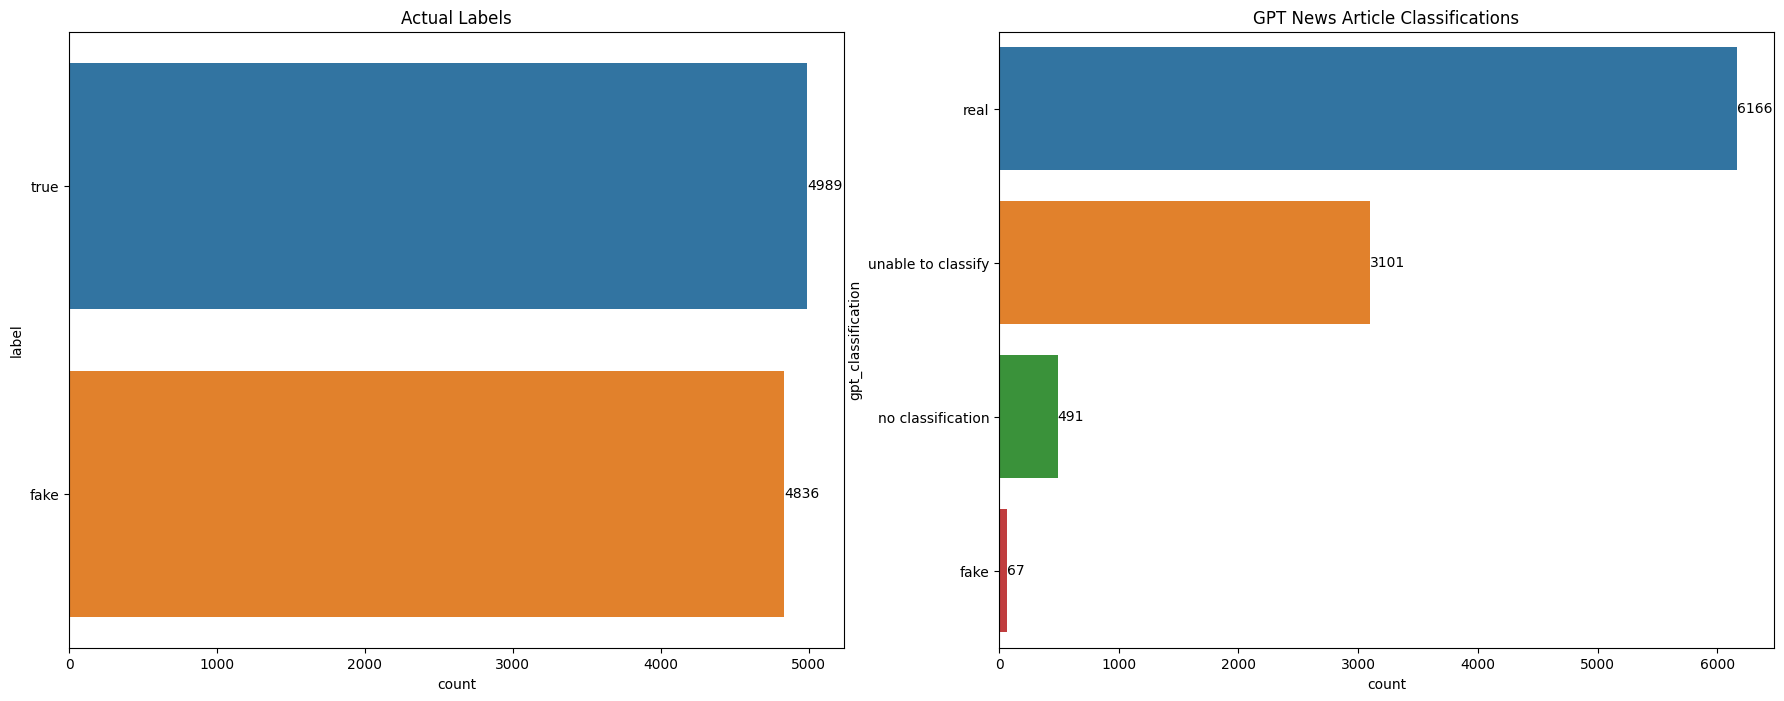

In [6]:
# Visualize the gpt_classification column
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22,8))

# Charts
label_bar = sns.countplot(data=df, y='label', ax=ax0)
label_bar.bar_label(label_bar.containers[0])
label_bar.set_title('Actual Labels')

gpt_class_bar = sns.countplot(data=df, y='gpt_classification', ax=ax1)
gpt_class_bar.bar_label(gpt_class_bar.containers[0])
gpt_class_bar.set_title('GPT News Article Classifications')

# Show
plt.show()

There are a large number of articles classified as 'true', and an extremely small amount classified as 'fake.' However, in this, there are a substantial number of articles where the model could not determine if an article was real or fake. Also, there were almost 500 articles where the model did not make a determination due to one of the following reasons:
1. The model did not think the text it received was a news article (tweet or opinion piece).
2. Limitations of the model as cited by itself.
3. Critiquing content quality, but not offering a classification of the article itself.

So, for LLMs, judging an article as fake or real has more nuance to it than traditional machine learning approaches that rely on stylometrics. To understand more about these articles, each of the LLM classifications will be reviewed.

## GPT Model Real Classification

Per the chart above, the LLM classified 6,166 articles it viewed as real. This is far greater than the actual amount of true labels in the subsetted data used in the analysis, which shows only 4,989 articles with a 'true' (real) classification.

In [7]:
# Subset trues from GPT classifications
gpt_true_df = df[df.gpt_classification=='real']

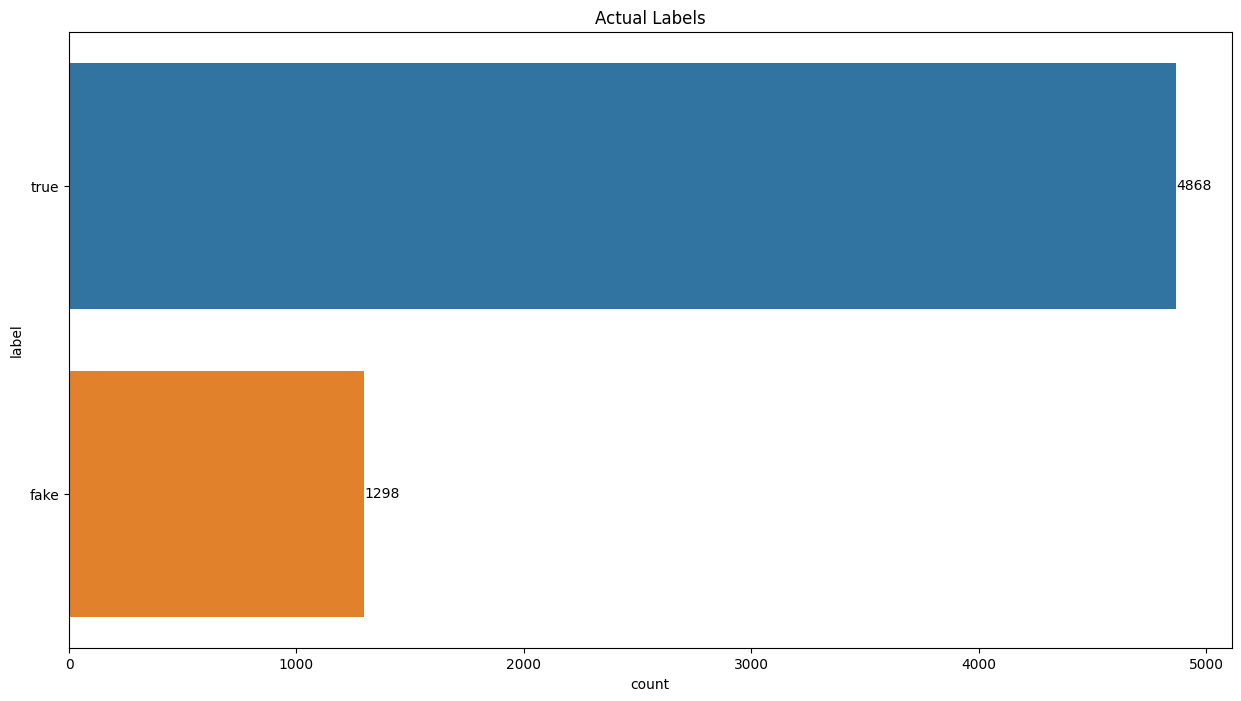

In [8]:
# Size
plt.figure(figsize=(15,8))

# Show the actual classifications
gpt_true_bar = sns.countplot(data=gpt_true_df, y='label')
gpt_true_bar.bar_label(gpt_true_bar.containers[0])
gpt_true_bar.set_title('Actual Labels')

# View
plt.show()

Interestingly, the LLM correctly identified 4,868 of the 4,989 actual true articles, but it also included 1,298 actual fake articles as part of the articles classified as real.

## GPT Model Fake Classification

The LLM classified only 67 articles as fake, which is incredibly low compared to the actual amount of fake articles (4,836).

In [9]:
# Subset fakes from GPT classifications
gpt_fake_df = df[df.gpt_classification=='fake']

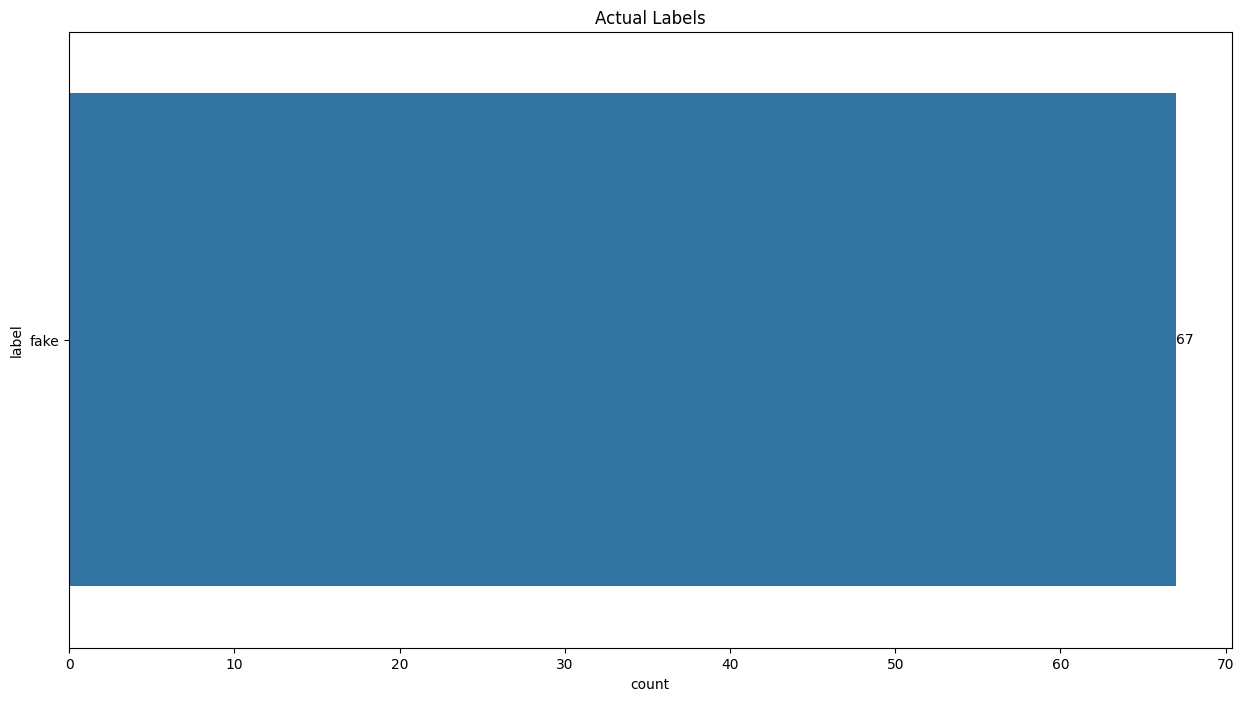

In [10]:
# Size
plt.figure(figsize=(15,8))

# Show the actual classifications
gpt_fake_bar = sns.countplot(data=gpt_fake_df, y='label')
gpt_fake_bar.bar_label(gpt_fake_bar.containers[0])
gpt_fake_bar.set_title('Actual Labels')

# View
plt.show()

Interestingly, every single article the LLM classified as fake was actually fake. At this point, there's an important question to ask: What are the difference in features between the fake articles judged as true, and the fake articles judged as fake? Some insights might be found in the text metrics computed in the first phase of this study.

Alternatively, it might be something to do with the content of the articles themselves.

## GPT Model Unable to Classify

According to the LLM, it was unable to classify 3,191 articles.

In [11]:
# Subset unable from GPT classifications
gpt_unable_df = df[df.gpt_classification=='unable to classify']

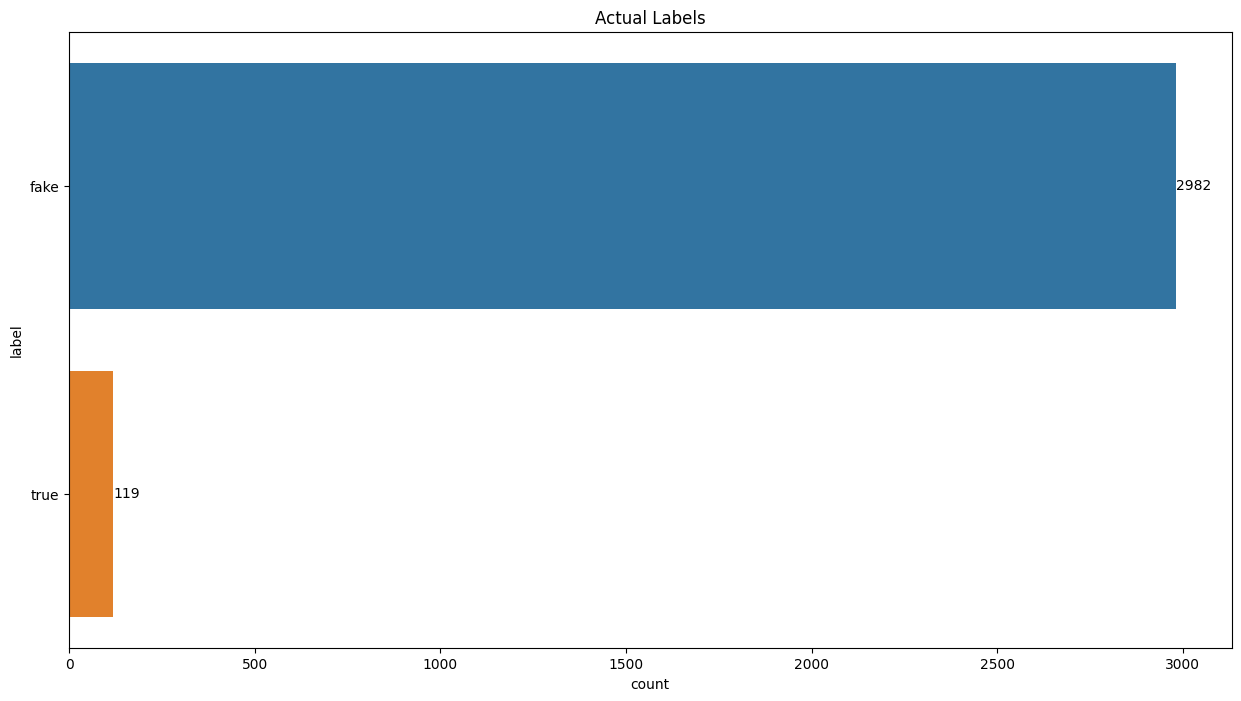

In [12]:
# Size
plt.figure(figsize=(15,8))

# Show the actual classifications
gpt_unable_bar = sns.countplot(data=gpt_unable_df, y='label')
gpt_unable_bar.bar_label(gpt_unable_bar.containers[0])
gpt_unable_bar.set_title('Actual Labels')

# View
plt.show()

Nearly the entirety of articles the LLM was unable to classify were fake articles. Only 119 were true. 

## GPT Model No Classification

The LLM offered no classification for 491 articles in the subsetted data. 

In [13]:
# Subset none from GPT classifications
gpt_none_df = df[df.gpt_classification=='no classification']

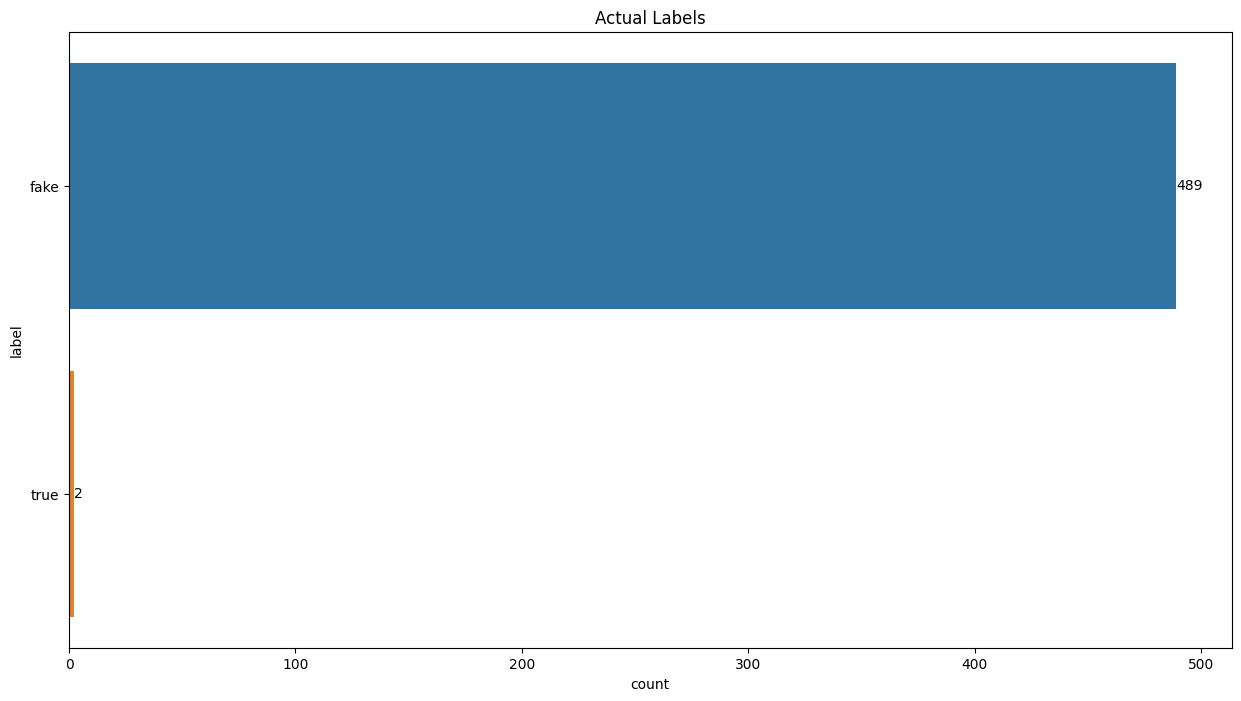

In [14]:
# Size
plt.figure(figsize=(15,8))

# Show the actual classifications
gpt_none_bar = sns.countplot(data=gpt_none_df, y='label')
gpt_none_bar.bar_label(gpt_none_bar.containers[0])
gpt_none_bar.set_title('Actual Labels')

# View
plt.show()

At this point it ceases to be surprising that the abundance of articles for which the LLM offered no classification were fake articles, and only 2 were real.

For now, it's worth considering some of the text metrics from the previous phase of this study to understand whether that can provide some insight into how these classifications came about.

## Text Metrics Inclusion

To begin, the text metric dataset needs to be imported and then joined on the matching index values. This is a bit of a challenge as the real and fake data sets were simply concatenated and their original index values not tracked. However, the work can still be done.

Also, please note that the LLM only saw the article text. It did not see the title text. Therefore, only the text-related columns will be used in this portion of the analysis.

In [15]:
# Import
text_metrics = pd.read_pickle('/kaggle/input/count-features/count_features_df.pkl')

# Check
text_metrics.head(3)

,title_token_counts,title_char_counts,title_sentence_counts,texts_token_counts,texts_char_counts,texts_sentence_counts,title_ner_counts,texts_ner_counts,title_avg_wps,title_avg_cps,title_avg_cpw,title_stopword_counts,text_avg_wps,text_avg_cps,text_avg_cpw,text_stopword_counts,label
0,14,64,2,600,2071,31,1,78,7.0,32.0,4.57,4,19.35,66.81,3.45,203,fake
1,8,61,1,348,1544,15,1,44,8.0,61.0,7.62,0,23.20,102.93,4.44,135,fake
2,17,73,1,692,2521,33,1,67,17.0,73.0,4.29,6,20.97,76.39,3.64,248,fake


In [16]:
# Starting index of fake labels
fake_start_text = 0
real_start_text = 23481

# Build the real index list
real_idx_list = [real_start_text+df.index[i] for i in range(df.shape[0]) if df.label[i] == 'true']

In [17]:
# Columns to copy over from text_metrics
text_cols_take = [col for col in text_metrics.columns if 'text' in col]

In [18]:
# New dataframe
meta_gpt = df.copy(deep=True)

# Create new columns
for col in text_cols_take:
    # Initialize as NaN
    meta_gpt[col] = np.nan
    
# Check
meta_gpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9825 entries, 0 to 9824
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  9825 non-null   int64  
 1   title                  9825 non-null   object 
 2   text                   9825 non-null   object 
 3   subject                9825 non-null   object 
 4   date                   9825 non-null   object 
 5   label                  9825 non-null   object 
 6   cleaned_text           9825 non-null   object 
 7   openai_min_responses   9825 non-null   object 
 8   openai_min_times       9825 non-null   float64
 9   gpt_classification     9825 non-null   object 
 10  texts_token_counts     0 non-null      float64
 11  texts_char_counts      0 non-null      float64
 12  texts_sentence_counts  0 non-null      float64
 13  texts_ner_counts       0 non-null      float64
 14  text_avg_wps           0 non-null      float64
 15  text

In [19]:
# Update the new columns
for i in tqdm(range(meta_gpt.shape[0])):
    # Get the index value - index[i] if fake, plus real_start_text if true
    idx = meta_gpt['index'][i] if meta_gpt.label[i] == 'fake' else meta_gpt['index'][i]+real_start_text
    # Update text columns
    for col in text_cols_take:
        # Take the value from text_metrics that matches index value to put in current i
        meta_gpt.loc[i,col] = text_metrics.loc[idx,col]

100%|██████████| 9825/9825 [00:09<00:00, 1029.87it/s]


In [20]:
# Check details again
meta_gpt.head(5)

,index,title,text,subject,date,label,cleaned_text,openai_min_responses,openai_min_times,gpt_classification,texts_token_counts,texts_char_counts,texts_sentence_counts,texts_ner_counts,text_avg_wps,text_avg_cps,text_avg_cpw,text_stopword_counts
0,6487,Clinton visits North Carolina in campaign trai...,"GREENSBORO, N.C. (Reuters) - Hillary Clinton g...",politicsNews,"September 15, 2016",true,Hillary Clinton got back on the campaign trail...,"Based on the information provided, this news a...",4.802724,real,727.0,3445.0,23.0,80.0,31.61,149.78,4.74,287.0
1,431,Watch Chris Christie Awkwardly Squirm In Avoi...,There are moments in life when you have to adm...,News,"March 1, 2016",fake,There are moments in life when you have to adm...,"Based on the provided text, it is difficult to...",4.406852,unable to classify,467.0,1885.0,14.0,43.0,33.36,134.64,4.04,176.0
2,7644,Puerto Rico rescue plan strains U.S. Republica...,WASHINGTON (Reuters) - Leading Republicans on ...,politicsNews,"April 12, 2016",true,Leading Republicans on Tuesday outlined a plan...,"Based on the information provided, this news a...",4.533700,real,447.0,1778.0,14.0,51.0,31.93,127.00,3.98,188.0
3,1875,EP 6: Patrick Henningsen LIVE with guest Rober...,Join Patrick every Wednesday at Independent T...,US_News,"December 22, 2016",fake,Join Patrick every Wednesday at Independent T...,"Based on the information provided, it is not p...",4.954600,unable to classify,498.0,1904.0,22.0,34.0,22.64,86.55,3.82,214.0
4,2471,Trump Fan Violently Attacks Black Protester —...,"Donald Trump seems to love it when his rabid, ...",News,"March 10, 2016",fake,"Donald Trump seems to love it when his rabid, ...","I'm sorry, but I can't provide an assessment o...",2.345610,unable to classify,553.0,2110.0,32.0,32.0,17.28,65.94,3.82,252.0


In [21]:
# Sizing
meta_gpt.shape

(9825, 18)

### GPT Real Classification Text Metrics

In [22]:
# Subset to gpt_classification == real
meta_real = meta_gpt[meta_gpt.gpt_classification == 'real']

# Show
print(f'There were {meta_real.shape[0]} records found.')

There were 6166 records found.


#### Text Token Counts

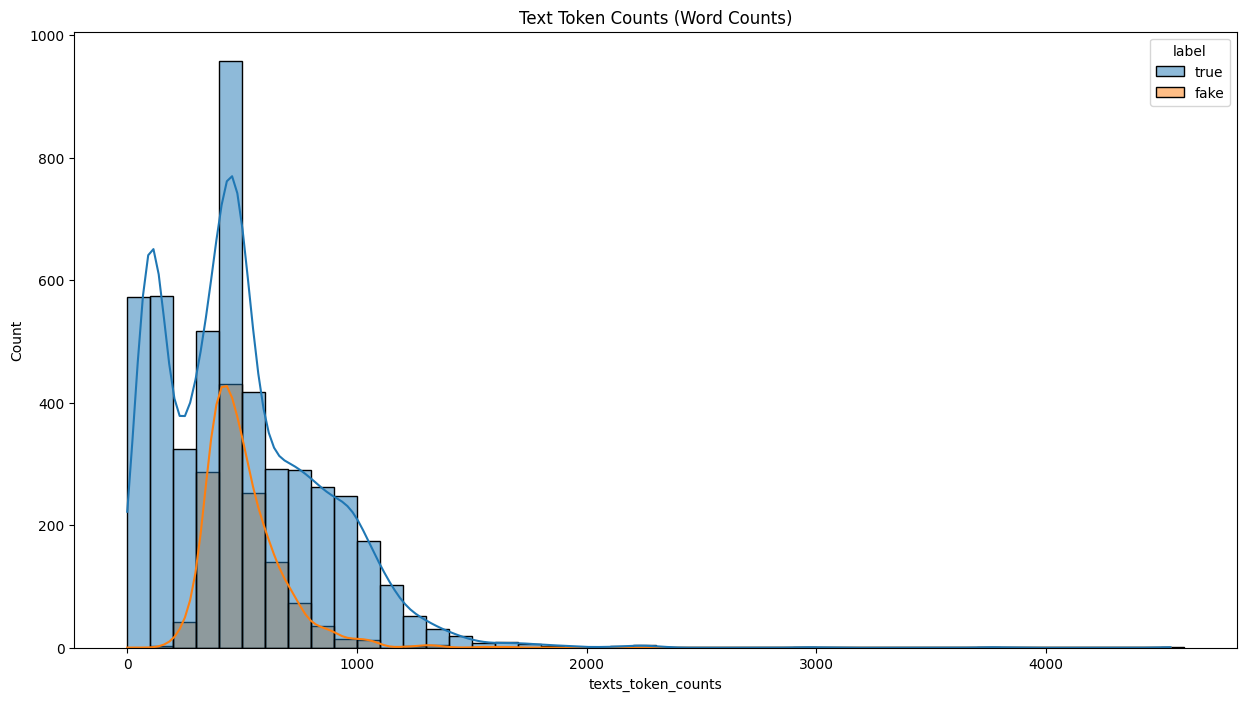

In [23]:
# Text Tokens
plt.figure(figsize=(15,8))

# Histograms
meta_real_hist = sns.histplot(data=meta_real, x='texts_token_counts', binwidth=100, kde=True, hue='label')
meta_real_hist.set_title('Text Token Counts (Word Counts)')

# Show
plt.show()

In [24]:
# Group by of actual labels for stats on texts_token_counts
meta_real.groupby(['label'])['texts_token_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,1298.0,506.165639,164.206696,176.0,398.00,470.0,576.75,1648.0
true,4868.0,496.028348,343.988679,0.0,233.75,452.0,699.00,4541.0


In [25]:
# Perform Kolmogorov-Smirnov Test
real_texttoken_ks = stats.ks_2samp(meta_real.texts_token_counts[meta_real.label=='fake'], meta_real.texts_token_counts[meta_real.label=='true'])
p_value = real_texttoken_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have different shapes.


In terms of text token count, or word count (since all non-word or number tokens were filtered), there is overlap between the distributions of actual real and actual fake articles. However, the distributions themselves are not similarly shaped. So, this variable would not be an adequate explanation for why there were 1,298 actual fake articles misclassified as real by the LLM.

#### Text Char Counts

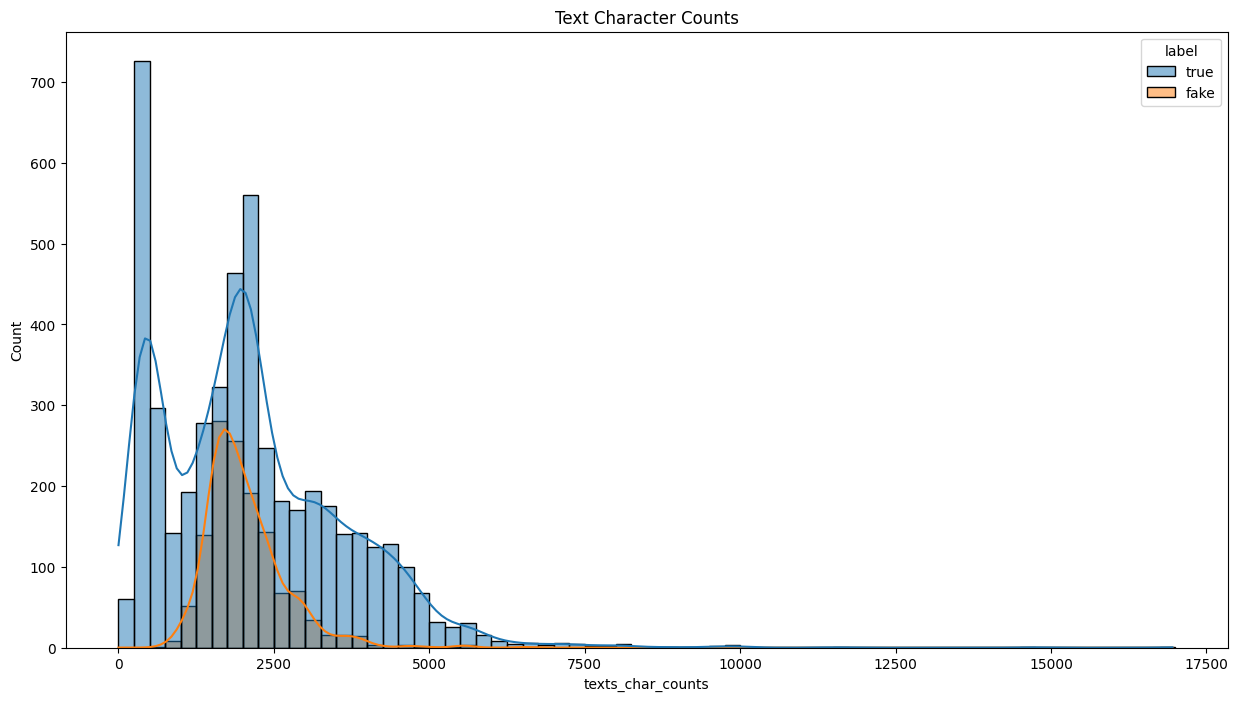

In [26]:
# Text Characters
plt.figure(figsize=(15,8))

# Histograms
meta_real_char = sns.histplot(data=meta_real, x='texts_char_counts', binwidth=250, kde=True, hue='label')
meta_real_char.set_title('Text Character Counts')

# Show
plt.show()

In [27]:
# Group by of actual labels for stats on texts_token_counts
meta_real.groupby(['label'])['texts_char_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,1298.0,2036.759630,633.758886,726.0,1620.25,1907.0,2323.0,6538.0
true,4868.0,2136.541085,1462.888156,0.0,986.50,1980.0,3016.0,16953.0


In [28]:
# Perform Kolmogorov-Smirnov Test
real_textchar_ks = stats.ks_2samp(meta_real.texts_char_counts[meta_real.label=='fake'], meta_real.texts_char_counts[meta_real.label=='true'])
p_value = real_textchar_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have different shapes.


Again, the distributions for count data between actual real and fake news articles overlap, this time for character counts. However, the lack of similarity in shape between the two distributions indicate we should keep looking for an explanation.

#### Text Sentence Counts

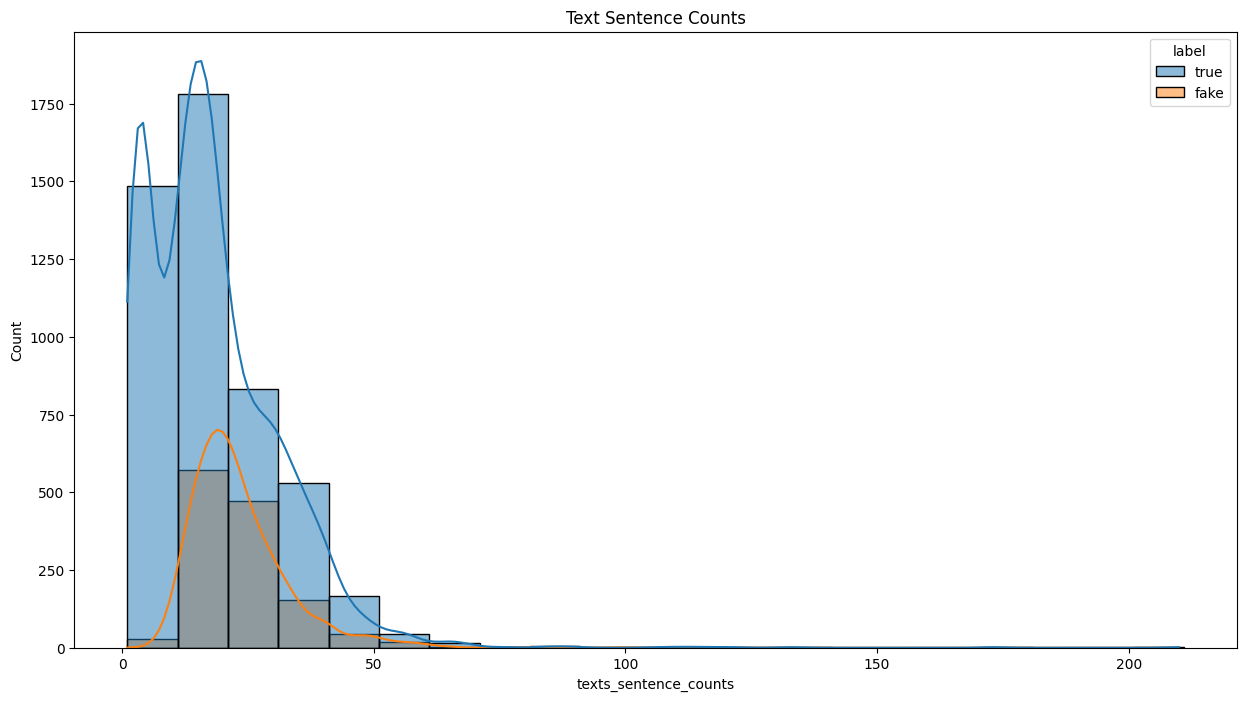

In [29]:
# Text Characters
plt.figure(figsize=(15,8))

# Histograms
meta_real_sent = sns.histplot(data=meta_real, x='texts_sentence_counts', binwidth=10, kde=True, hue='label')
meta_real_sent.set_title('Text Sentence Counts')

# Show
plt.show()

In [30]:
# Group by of actual labels for stats on texts_sentence_counts
meta_real.groupby(['label'])['texts_sentence_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,1298.0,23.214176,9.674839,6.0,17.0,21.0,27.00,99.0
true,4868.0,17.715283,13.254238,1.0,8.0,16.0,24.25,210.0


In [31]:
# Perform Kolmogorov-Smirnov Test
real_textsentence_ks = stats.ks_2samp(meta_real.texts_sentence_counts[meta_real.label=='fake'], meta_real.texts_sentence_counts[meta_real.label=='true'])
p_value = real_textsentence_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have different shapes.


Considering what's in the histogram, the distribution of sentences between actual real and fake articles overlaps.

Based on the above findings, calculated variables such as characters per word and per sentence, and words per sentence won't be investigated. However, NER and stopword counts will.

#### NER Counts

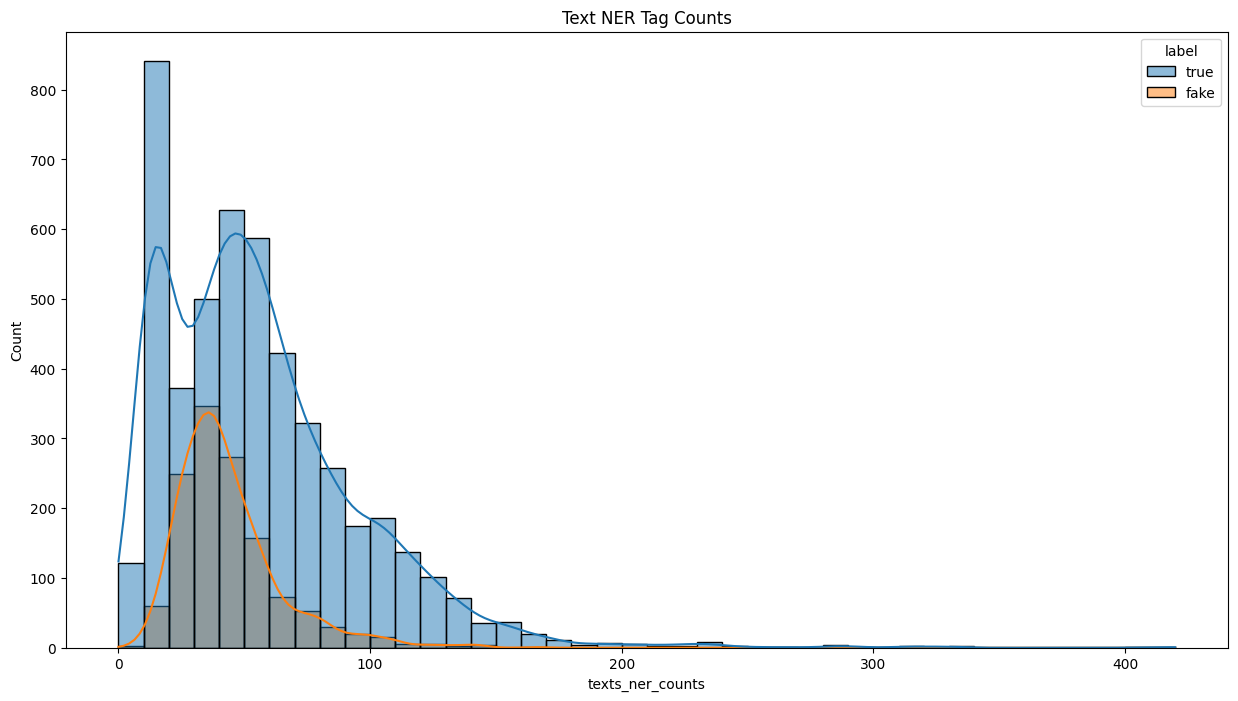

In [32]:
# NER
plt.figure(figsize=(15,8))

# Histograms
meta_real_ner = sns.histplot(data=meta_real, x='texts_ner_counts', binwidth=10, kde=True, hue='label')
meta_real_ner.set_title('Text NER Tag Counts')

# Show
plt.show()

In [33]:
# Group by of actual labels for stats on texts_ner_counts
meta_real.groupby(['label'])['texts_ner_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,1298.0,43.640216,20.792231,7.0,30.0,39.0,51.0,166.0
true,4868.0,55.868529,39.457967,0.0,26.0,49.0,74.0,420.0


In [34]:
# Perform Kolmogorov-Smirnov Test
real_ner_ks = stats.ks_2samp(meta_real.texts_ner_counts[meta_real.label=='fake'], meta_real.texts_ner_counts[meta_real.label=='true'])
p_value = real_ner_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have different shapes.


Although the distributions overlap, they are not similarly shaped. NER tag counts are not a good explanation for the misclassifications observed.

#### Stopwords

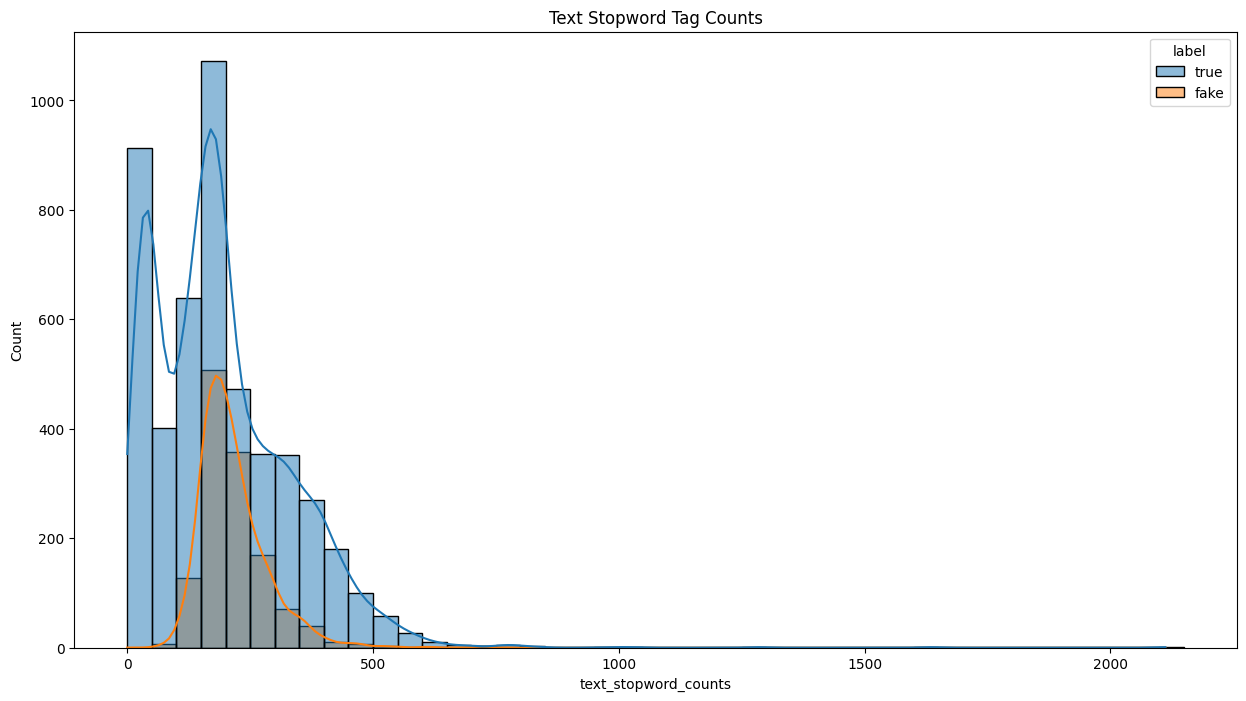

In [35]:
# stopwords
plt.figure(figsize=(15,8))

# Histograms
meta_real_stops = sns.histplot(data=meta_real, x='text_stopword_counts', binwidth=50, kde=True, hue='label')
meta_real_stops.set_title('Text Stopword Tag Counts')

# Show
plt.show()

In [36]:
# Group by of actual labels for stats on text_stopword_counts
meta_real.groupby(['label'])['text_stopword_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,1298.0,215.267334,68.653434,68.0,169.0,201.0,245.0,731.0
true,4868.0,191.935086,138.208025,0.0,86.0,173.0,271.0,2112.0


In [37]:
# Perform Kolmogorov-Smirnov Test
real_stops_ks = stats.ks_2samp(meta_real.text_stopword_counts[meta_real.label=='fake'], meta_real.text_stopword_counts[meta_real.label=='true'])
p_value = real_stops_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have different shapes.


After this final result, for the articles that the LLM classified as real, it appears that at a high level they shared similarity in style considering the overlap in distributions of these variables, but they are by no means an adequate explanation even when considered together. While this seems like the start of an explanation, the fake classifications must be examined next.

### GPT Fake Classification Text Metrics

Since there are only 67 articles that received the fake classification, and all 67 had actual fake classifications, there's no real value in investigating text metrics except to see how they compare to those metrics for the fake articles that were classified as real by the LLM.

In [38]:
# Subset to gpt_classification == fake
meta_fake = meta_gpt[meta_gpt.gpt_classification == 'fake']

# Show
print(f'There were {meta_fake.shape[0]} records found.')

There were 67 records found.


#### Text Token Count

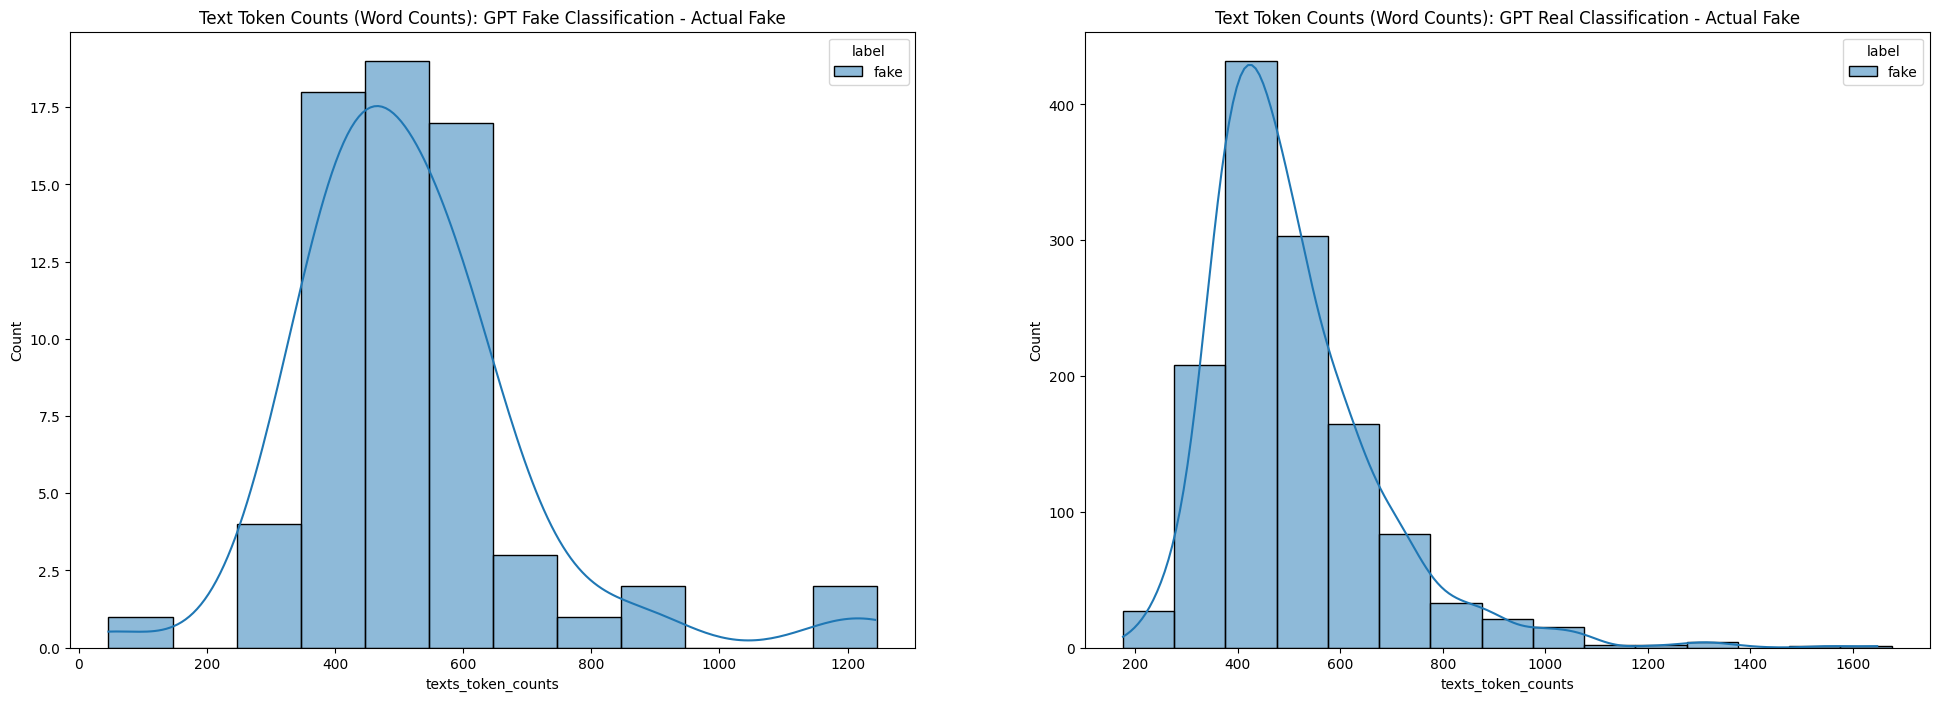

In [39]:
# Text Tokens
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0
ax0 = sns.histplot(data=meta_fake, x='texts_token_counts', binwidth=100, kde=True, hue='label', ax=ax0)
ax0.set_title('Text Token Counts (Word Counts): GPT Fake Classification - Actual Fake')

# Histograms
ax1 = sns.histplot(data=meta_real[meta_real.label=='fake'], x='texts_token_counts', binwidth=100, kde=True, hue='label', ax=ax1)
ax1.set_title('Text Token Counts (Word Counts): GPT Real Classification - Actual Fake')

# Show
plt.show()

In [40]:
# Describe as dataframe
mr_fake_desc = pd.DataFrame(meta_real.texts_token_counts[meta_real.label=='fake'].describe())
mf_fake_desc = pd.DataFrame(meta_fake.texts_token_counts[meta_fake.label=='fake'].describe())

# Join
mr_fake_desc.join(mf_fake_desc, how='left', lsuffix='_gpt_real', rsuffix='_gpt_fake')

,texts_token_counts_gpt_real,texts_token_counts_gpt_fake
count,1298.000000,67.000000
mean,506.165639,515.746269
std,164.206696,184.739730
min,176.000000,46.000000
25%,398.000000,408.500000
50%,470.000000,495.000000
75%,576.750000,587.000000
max,1648.000000,1243.000000


In [41]:
# Perform Kolmogorov-Smirnov Test
fake_texttoken_ks = stats.ks_2samp(meta_real.texts_token_counts[meta_real.label=='fake'], meta_fake.texts_token_counts[meta_fake.label=='fake'])
p_value = fake_texttoken_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


At this point, this is an interesting finding. Unsurprisingly, the actual fake articles between the gpt classified true and gpt classified false have similar shapes, but their score distributions vary slightly.

#### Text Character Count

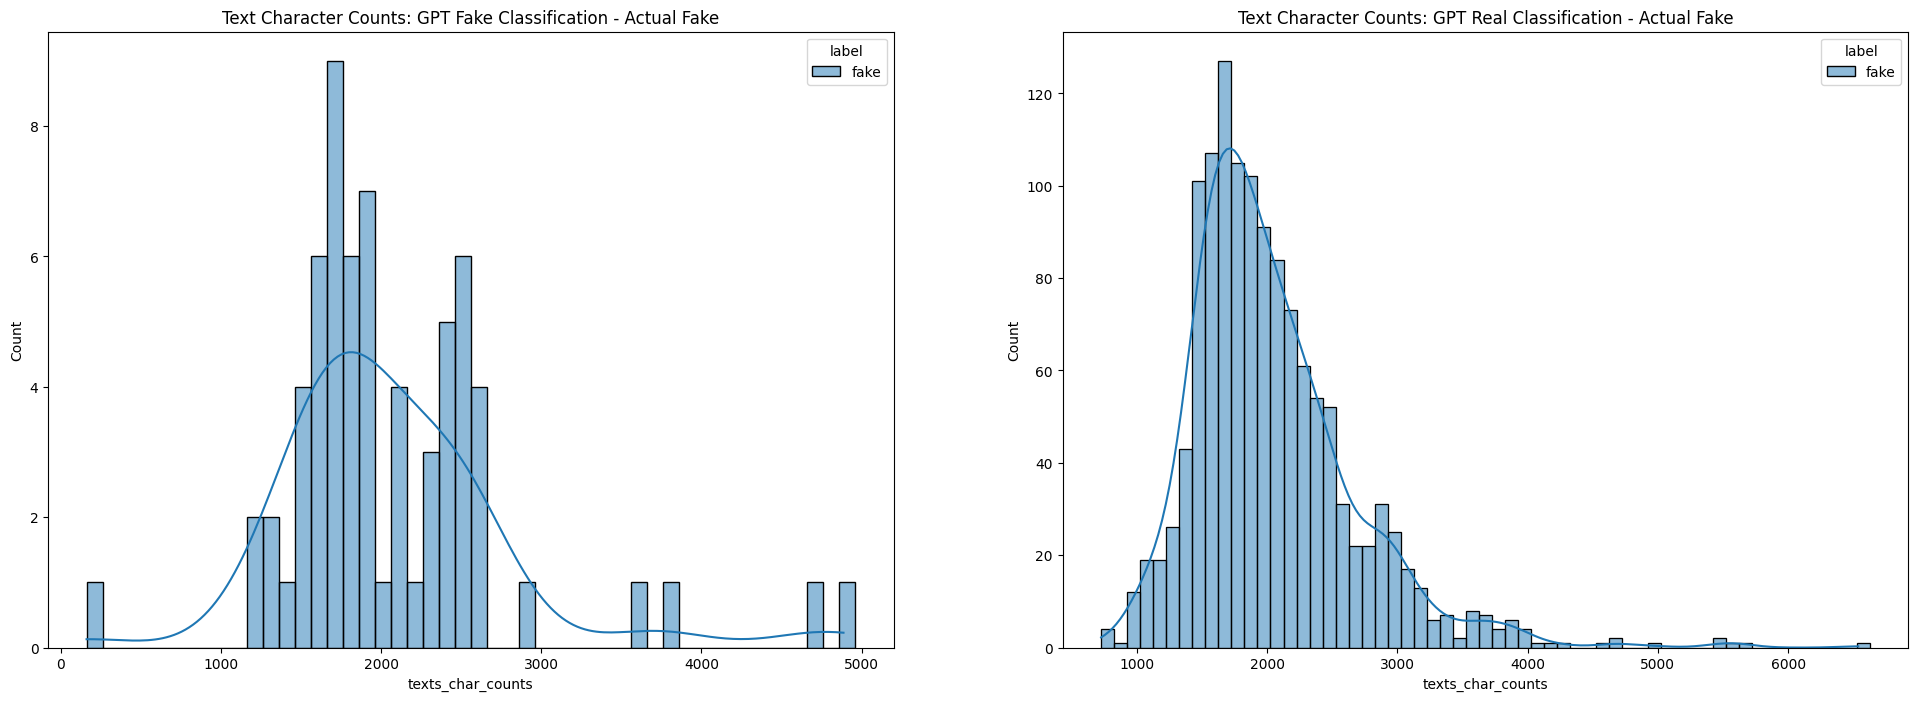

In [42]:
# Text chars
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0
ax0 = sns.histplot(data=meta_fake, x='texts_char_counts', binwidth=100, kde=True, hue='label', ax=ax0)
ax0.set_title('Text Character Counts: GPT Fake Classification - Actual Fake')

# Histograms
ax1 = sns.histplot(data=meta_real[meta_real.label=='fake'], x='texts_char_counts', binwidth=100, kde=True, hue='label', ax=ax1)
ax1.set_title('Text Character Counts: GPT Real Classification - Actual Fake')

# Show
plt.show()

In [43]:
# Describe as dataframe
mr_fake_char = pd.DataFrame(meta_real.texts_char_counts[meta_real.label=='fake'].describe())
mf_fake_char = pd.DataFrame(meta_fake.texts_char_counts[meta_fake.label=='fake'].describe())

# Join
mr_fake_char.join(mf_fake_char, how='left', lsuffix='_gpt_real', rsuffix='_gpt_fake')

,texts_char_counts_gpt_real,texts_char_counts_gpt_fake
count,1298.000000,67.000000
mean,2036.759630,2076.805970
std,633.758886,728.624259
min,726.000000,160.000000
25%,1620.250000,1670.000000
50%,1907.000000,1925.000000
75%,2323.000000,2428.500000
max,6538.000000,4887.000000


In [44]:
# Perform Kolmogorov-Smirnov Test
fake_textchar_ks = stats.ks_2samp(meta_real.texts_char_counts[meta_real.label=='fake'], meta_fake.texts_char_counts[meta_fake.label=='fake'])
p_value = fake_textchar_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


It seems that once again, the distributions are similarly shaped despite the appearances of the histograms.

#### Text Sentence Count

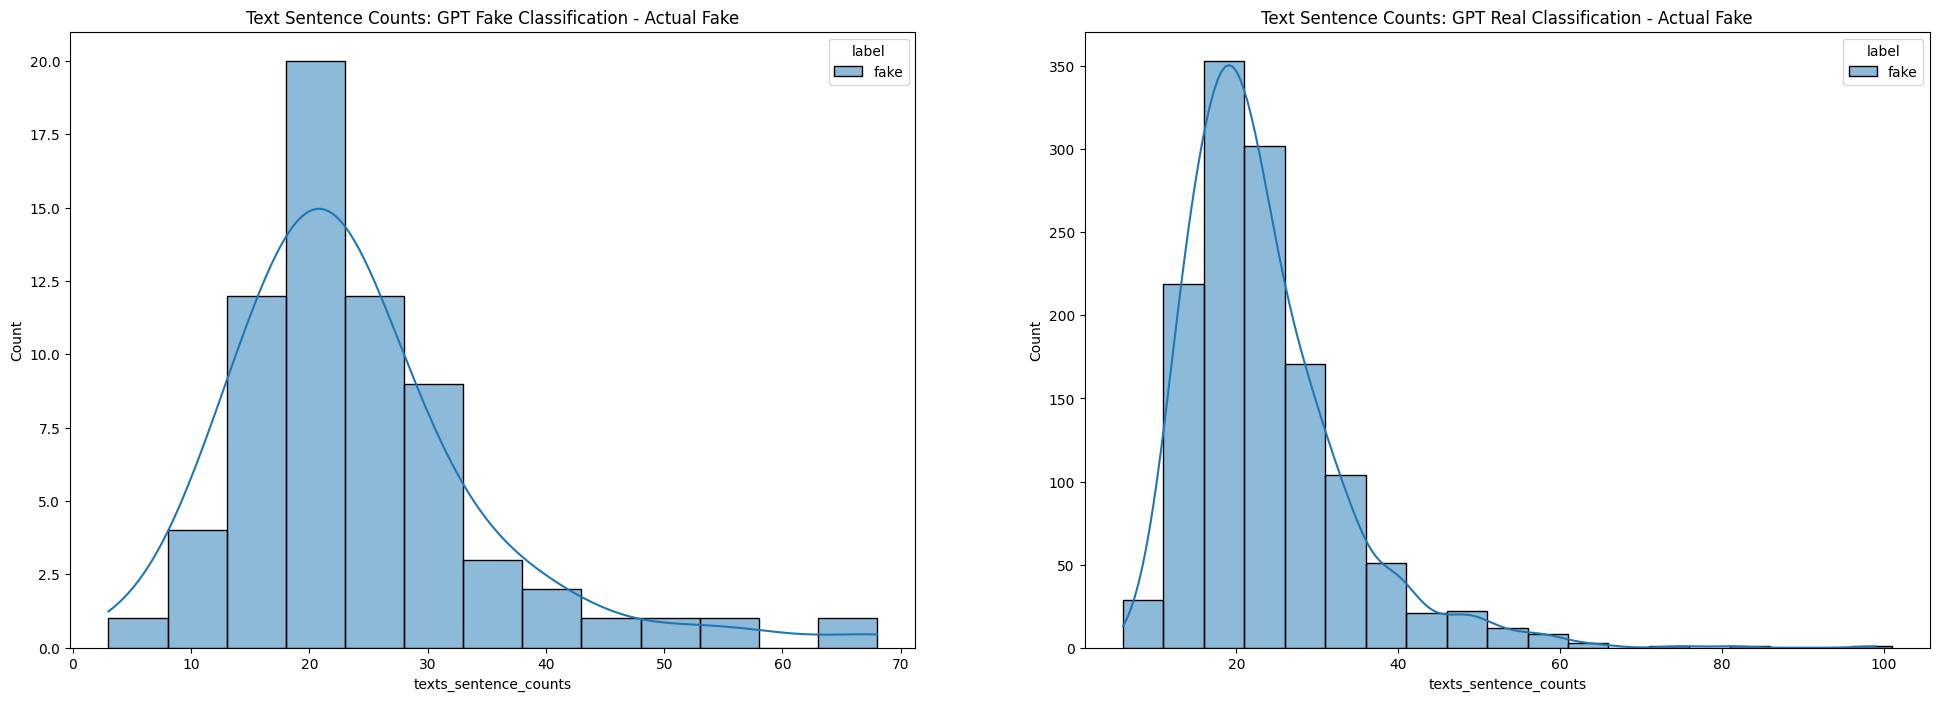

In [45]:
# Text sentence
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0
ax0 = sns.histplot(data=meta_fake, x='texts_sentence_counts', binwidth=5, kde=True, hue='label', ax=ax0)
ax0.set_title('Text Sentence Counts: GPT Fake Classification - Actual Fake')

# Histograms
ax1 = sns.histplot(data=meta_real[meta_real.label=='fake'], x='texts_sentence_counts', binwidth=5, kde=True, hue='label', ax=ax1)
ax1.set_title('Text Sentence Counts: GPT Real Classification - Actual Fake')

# Show
plt.show()

In [46]:
# Describe as dataframe
mr_fake_sent = pd.DataFrame(meta_real.texts_sentence_counts[meta_real.label=='fake'].describe())
mf_fake_sent = pd.DataFrame(meta_fake.texts_sentence_counts[meta_fake.label=='fake'].describe())

# Join
mr_fake_sent.join(mf_fake_char, how='left', lsuffix='_gpt_real', rsuffix='_gpt_fake')

,texts_sentence_counts,texts_char_counts
count,1298.000000,67.000000
mean,23.214176,2076.805970
std,9.674839,728.624259
min,6.000000,160.000000
25%,17.000000,1670.000000
50%,21.000000,1925.000000
75%,27.000000,2428.500000
max,99.000000,4887.000000


In [47]:
# Perform Kolmogorov-Smirnov Test
fake_textsent_ks = stats.ks_2samp(meta_real.texts_sentence_counts[meta_real.label=='fake'], meta_fake.texts_sentence_counts[meta_fake.label=='fake'])
p_value = fake_textsent_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


Unsurprisingly, the distributions are similarly shaped. Further indication that fake news articles have stylometric similarity, but it is not what the model is picking up on.

#### Text NER Tag Count

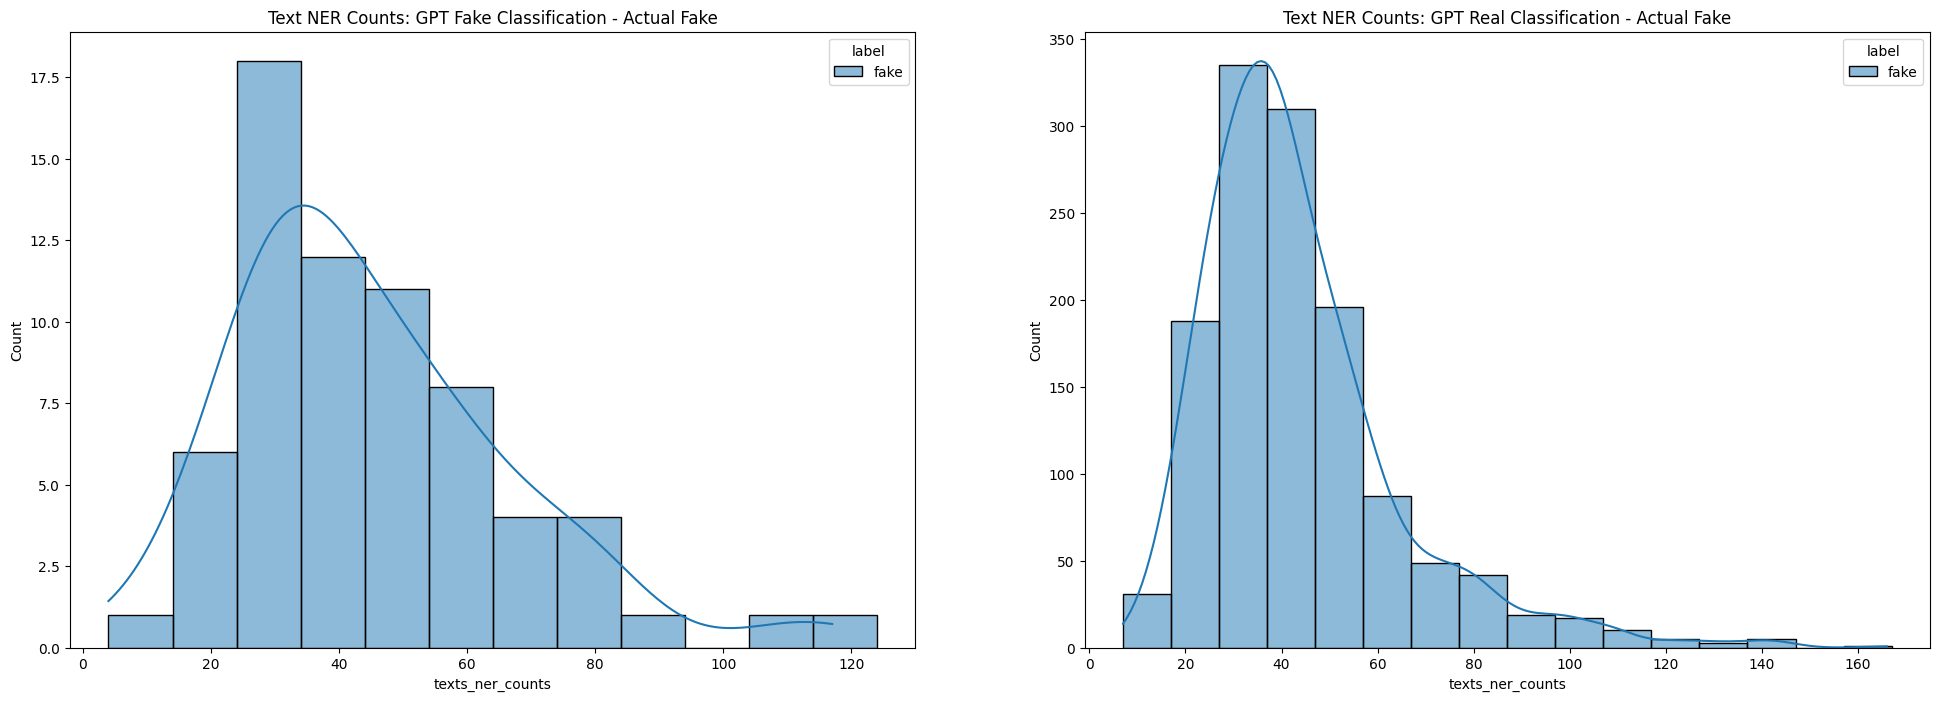

In [48]:
# Text NER
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0
ax0 = sns.histplot(data=meta_fake, x='texts_ner_counts', binwidth=10, kde=True, hue='label', ax=ax0)
ax0.set_title('Text NER Counts: GPT Fake Classification - Actual Fake')

# Histograms
ax1 = sns.histplot(data=meta_real[meta_real.label=='fake'], x='texts_ner_counts', binwidth=10, kde=True, hue='label', ax=ax1)
ax1.set_title('Text NER Counts: GPT Real Classification - Actual Fake')

# Show
plt.show()

In [49]:
# Describe as dataframe
mr_fake_ner = pd.DataFrame(meta_real.texts_ner_counts[meta_real.label=='fake'].describe())
mf_fake_ner = pd.DataFrame(meta_fake.texts_ner_counts[meta_fake.label=='fake'].describe())

# Join
mr_fake_ner.join(mf_fake_char, how='left', lsuffix='_gpt_real', rsuffix='_gpt_fake')

,texts_ner_counts,texts_char_counts
count,1298.000000,67.000000
mean,43.640216,2076.805970
std,20.792231,728.624259
min,7.000000,160.000000
25%,30.000000,1670.000000
50%,39.000000,1925.000000
75%,51.000000,2428.500000
max,166.000000,4887.000000


In [50]:
# Perform Kolmogorov-Smirnov Test
fake_ner_ks = stats.ks_2samp(meta_real.texts_ner_counts[meta_real.label=='fake'], meta_fake.texts_ner_counts[meta_fake.label=='fake'])
p_value = fake_ner_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


#### Text Stopword Counts

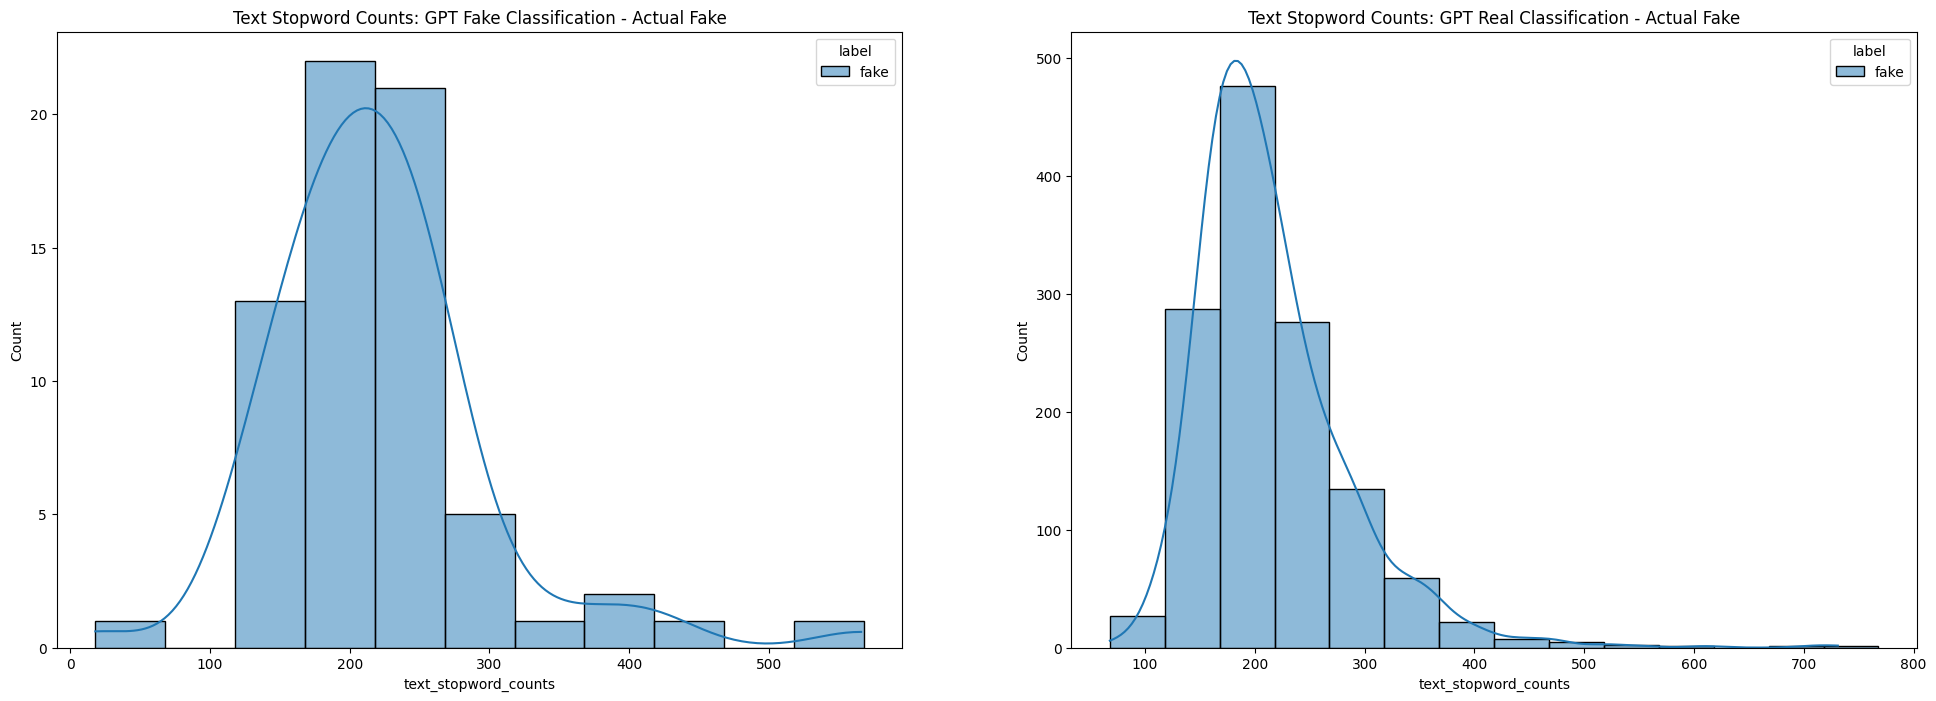

In [51]:
# Text stopwords
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0
ax0 = sns.histplot(data=meta_fake, x='text_stopword_counts', binwidth=50, kde=True, hue='label', ax=ax0)
ax0.set_title('Text Stopword Counts: GPT Fake Classification - Actual Fake')

# Histograms
ax1 = sns.histplot(data=meta_real[meta_real.label=='fake'], x='text_stopword_counts', binwidth=50, kde=True, hue='label', ax=ax1)
ax1.set_title('Text Stopword Counts: GPT Real Classification - Actual Fake')

# Show
plt.show()

In [52]:
# Perform Kolmogorov-Smirnov Test
fake_stops_ks = stats.ks_2samp(meta_real.text_stopword_counts[meta_real.label=='fake'], meta_fake.text_stopword_counts[meta_fake.label=='fake'])
p_value = fake_stops_ks.pvalue

# Print out the results
if p_value < 0.05:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


After this analysis, it's safe to say that the LLM was not picking up on any stylistic differences between what it classified as real or fake articles compared to actual real and fake articles. Therefore, the next step to look at is actual content.

## Fact Identification and Fact Checking

Given the quality of feedback provided by the LLM that seemed focused on the content of the articles themselves, the next logical step in the analysis is to look at the content. Since this is a study on fake vs real news detection, an interesting approach is to use the LLM as a fact identification and checker.

(Please note that it costs money to use an LLM for such work, so the data set sizes from this point on will be getting smaller. This was done to ensure I had enough credits to perform my desired analyses.)

In [53]:
# Import the dataset
facts = pd.read_pickle('/kaggle/input/fact-checked-gpt35/checked_for_kaggle.pkl')

# Check
facts.head(3)

,index,title,text,subject,date,label,cleaned_text,fact_list,gpt35_determinations,fact_counts,gpt35_true_counts,gpt35_false_counts,gpt35_undetermined_counts
0,6487,Clinton visits North Carolina in campaign trai...,"GREENSBORO, N.C. (Reuters) - Hillary Clinton g...",politicsNews,"September 15, 2016",true,Hillary Clinton got back on the campaign trail...,[Hillary Clinton returned to the campaign trai...,"[True, True, True, True, True, True, True, Tru...",14,13,0,1
1,431,Watch Chris Christie Awkwardly Squirm In Avoi...,There are moments in life when you have to adm...,News,"March 1, 2016",fake,There are moments in life when you have to adm...,[New Jersey Gov. Chris Christie endorsed Donal...,"[True, True, Undetermined, True, Undetermined,...",7,3,0,4
2,7644,Puerto Rico rescue plan strains U.S. Republica...,WASHINGTON (Reuters) - Leading Republicans on ...,politicsNews,"April 12, 2016",true,Leading Republicans on Tuesday outlined a plan...,[Leading Republicans have outlined a plan to h...,"[True, True, True, True, True, True, True, Tru...",12,12,0,0


Once again, this new dataframe and meta_gpt will need to be combined.

In [54]:
# Merge
meta_facts = facts.merge(meta_gpt, left_on='index', right_on='index', how='inner', suffixes=('_meta', '_facts'))

# Check
meta_facts.shape

(4925, 30)

In [55]:
# Columns
meta_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4925 entries, 0 to 4924
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      4925 non-null   int64  
 1   title_meta                 4925 non-null   object 
 2   text_meta                  4925 non-null   object 
 3   subject_meta               4925 non-null   object 
 4   date_meta                  4925 non-null   object 
 5   label_meta                 4925 non-null   object 
 6   cleaned_text_meta          4925 non-null   object 
 7   fact_list                  4925 non-null   object 
 8   gpt35_determinations       4925 non-null   object 
 9   fact_counts                4925 non-null   int64  
 10  gpt35_true_counts          4925 non-null   int64  
 11  gpt35_false_counts         4925 non-null   int64  
 12  gpt35_undetermined_counts  4925 non-null   int64  
 13  title_facts                4925 non-null   objec

In [56]:
# Columns to drop
drop_cols = [col for col in meta_facts.columns if '_facts' in col]

# Drop
facts_df = meta_facts.drop(columns=drop_cols)

# Check
facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4925 entries, 0 to 4924
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      4925 non-null   int64  
 1   title_meta                 4925 non-null   object 
 2   text_meta                  4925 non-null   object 
 3   subject_meta               4925 non-null   object 
 4   date_meta                  4925 non-null   object 
 5   label_meta                 4925 non-null   object 
 6   cleaned_text_meta          4925 non-null   object 
 7   fact_list                  4925 non-null   object 
 8   gpt35_determinations       4925 non-null   object 
 9   fact_counts                4925 non-null   int64  
 10  gpt35_true_counts          4925 non-null   int64  
 11  gpt35_false_counts         4925 non-null   int64  
 12  gpt35_undetermined_counts  4925 non-null   int64  
 13  openai_min_responses       4925 non-null   objec

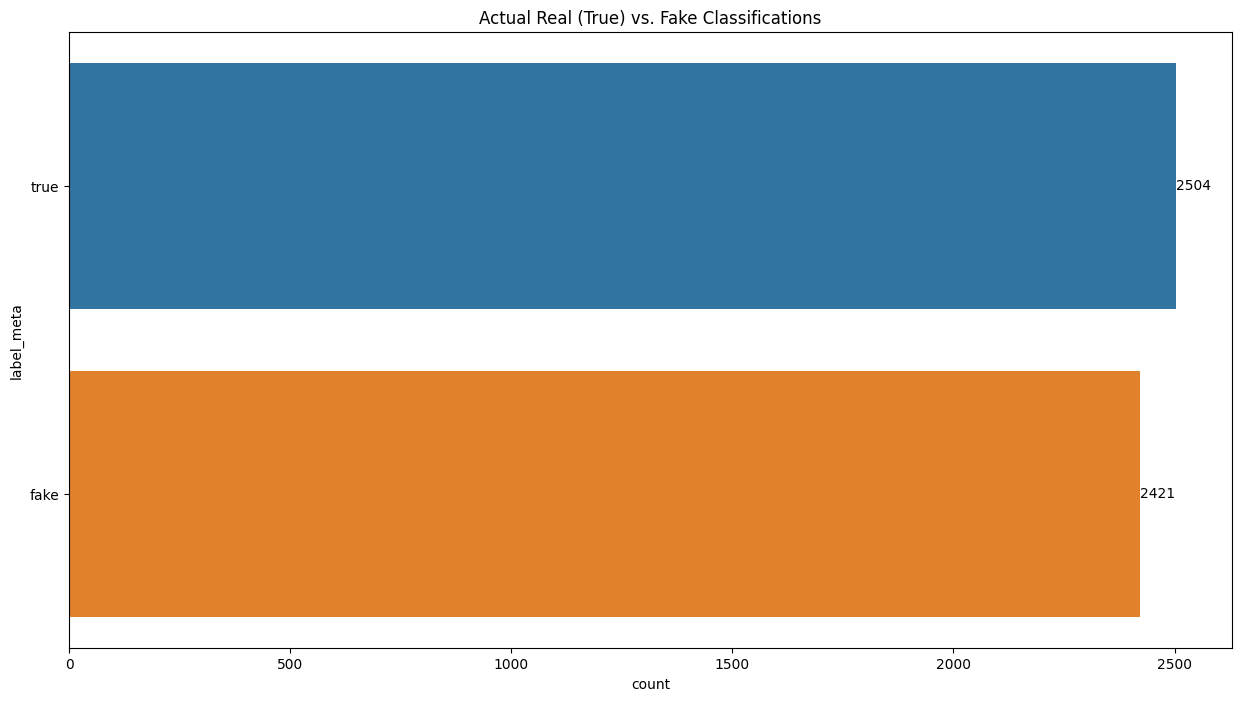

In [57]:
# Graph to show split of real and fake
plt.figure(figsize=(15,8))
facts_actual = sns.countplot(data=facts_df, y='label_meta')
facts_actual.bar_label(facts_actual.containers[0])
plt.title('Actual Real (True) vs. Fake Classifications')
plt.show()

In [58]:
# Subset
gpt_true_facts = facts_df[facts_df.gpt_classification == 'real']

# Check
print(f'There were {gpt_true_facts.shape[0]} records identified.')

There were 3104 records identified.


In [59]:
# Subset
gpt_fake_facts = facts_df[facts_df.gpt_classification == 'fake']

# Check
print(f'There were {gpt_fake_facts.shape[0]} records identified.')

There were 38 records identified.


### GPT True Classification Facts

The point of this investigation is to determine whether the facts identified in an article, and the judgment of them as true, false, or undetermined, can be tied to the observed misclassifications of real news articles and fake news articles.

Before beginning, it's worth looking at the breakdown of real (true) vs. fake articles.

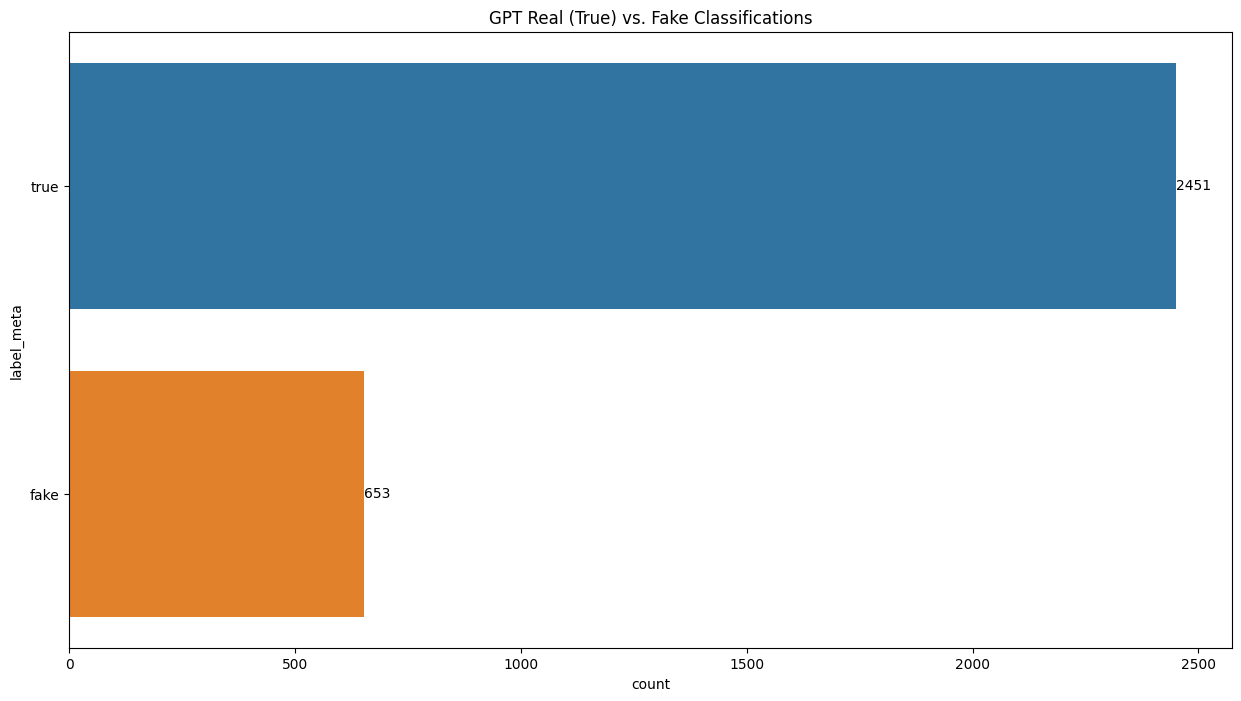

In [60]:
# Graph to show split of real and fake
plt.figure(figsize=(15,8))
gpt_fact_true = sns.countplot(data=gpt_true_facts, y='label_meta')
gpt_fact_true.bar_label(gpt_fact_true.containers[0])
plt.title('GPT Real (True) vs. Fake Classifications')
plt.show()

#### Count of facts

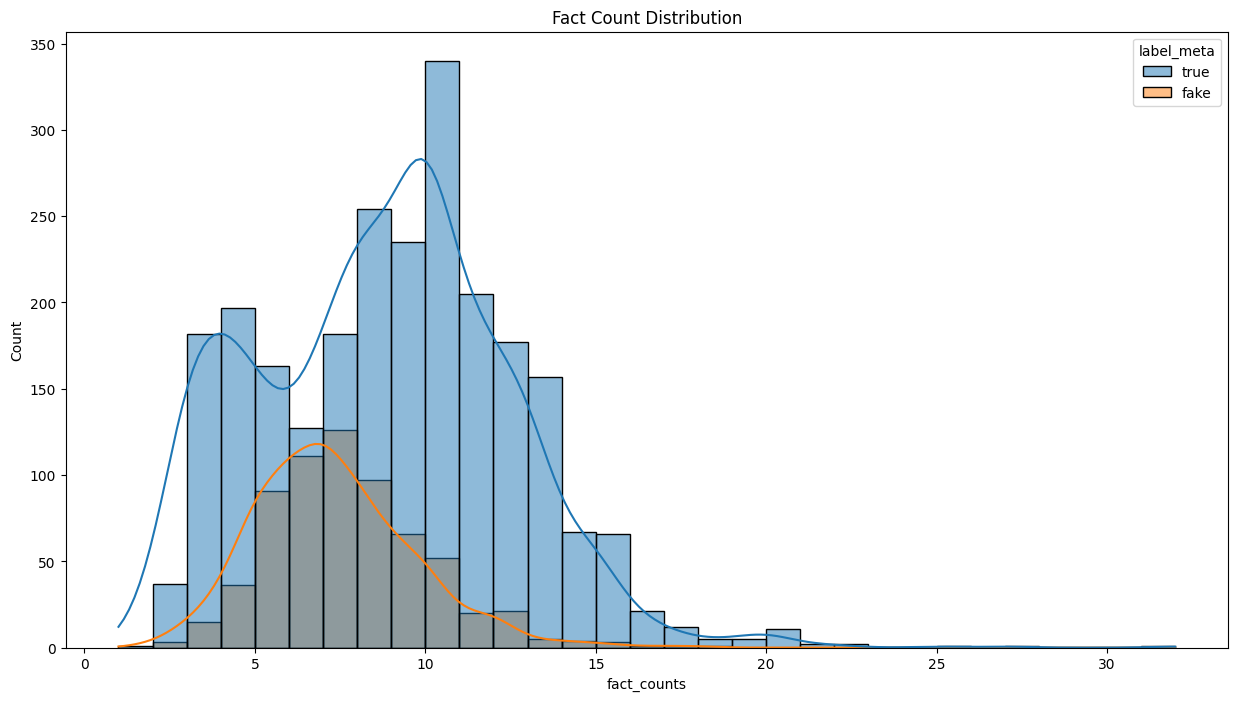

In [61]:
# Fact count
plt.figure(figsize=(15,8))

# Histogram
gft_count = sns.histplot(data=gpt_true_facts, x='fact_counts', binwidth=1, kde=True, hue='label_meta')
gft_count.set_title('Fact Count Distribution')

# Show
plt.show()

In [62]:
# Grouping
gpt_true_facts.groupby(['label_meta'])['fact_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label_meta,,,,,,,,
fake,653.0,7.315467,2.347500,2.0,6.0,7.0,9.0,18.0
true,2451.0,8.678091,3.665449,1.0,6.0,9.0,11.0,32.0


In [63]:
# Perform Kolmogorov-Smirnov Test
gft_facts_ks = stats.ks_2samp(gpt_true_facts.fact_counts[gpt_true_facts.label_meta=='fake'], gpt_true_facts.fact_counts[gpt_true_facts.label_meta=='fake'])
p_value = gft_facts_ks.pvalue

# Print out the results
if p_value < 0.05/2:
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


Interestingly, the number of facts identified in actual fake articles and actual real articles that were classified as real by the LLM appear to be distributed similarly. This means that it's possible the fact content is similar enough between these elements to have contributed to misclassification. (Though it may not be the only cause.) An interesting question to answer would be to determine whether the observed fact counts for actual classifications versus gpt classifications is what would be expected.

#### Number of True Facts

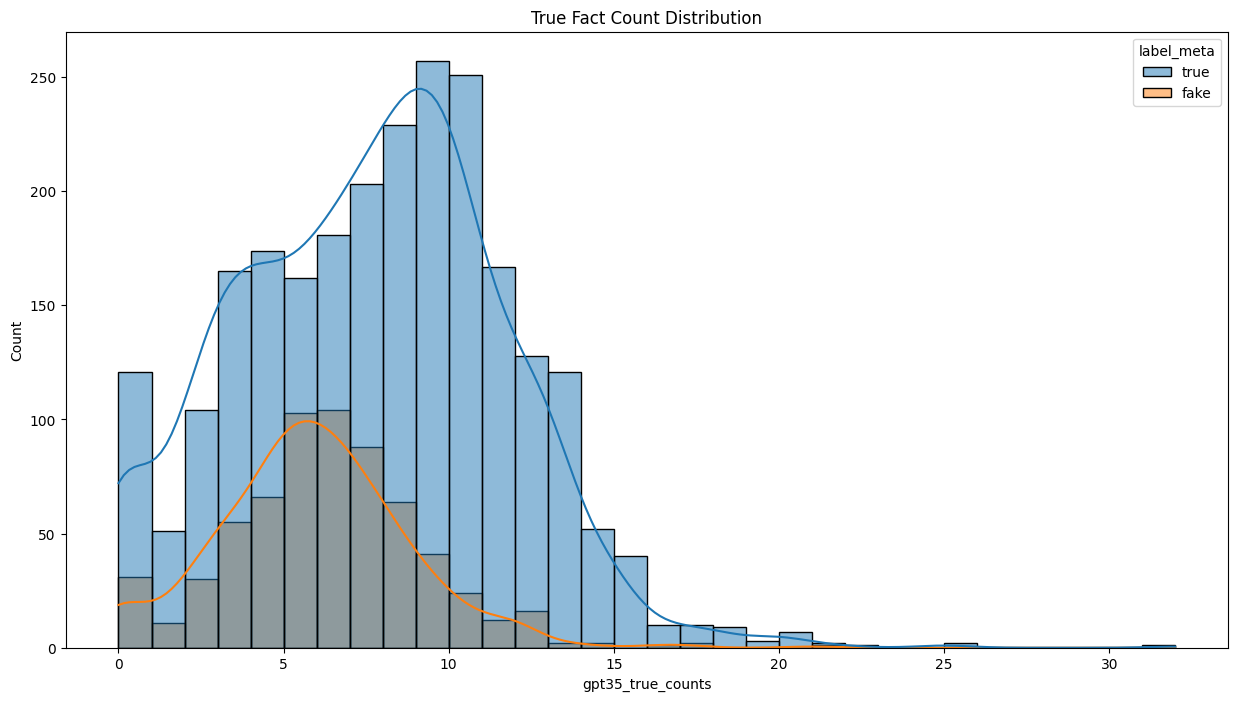

In [64]:
# Fact count
plt.figure(figsize=(15,8))

# Histogram
gft_count = sns.histplot(data=gpt_true_facts, x='gpt35_true_counts', binwidth=1, kde=True, hue='label_meta')
gft_count.set_title('True Fact Count Distribution')

# Show
plt.show()

In [65]:
# Grouping
gpt_true_facts.groupby(['label_meta'])['gpt35_true_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label_meta,,,,,,,,
fake,653.0,5.857580,2.900644,0.0,4.0,6.0,8.0,21.0
true,2451.0,7.560588,4.034836,0.0,4.0,8.0,10.0,32.0


In [66]:
# Perform Kolmogorov-Smirnov Test - Are they from the same distribution?
gft_true_ks = stats.ks_2samp(gpt_true_facts.gpt35_true_counts[gpt_true_facts.label_meta=='fake'], gpt_true_facts.gpt35_true_counts[gpt_true_facts.label_meta=='fake'])
p_value = gft_true_ks.pvalue

# Print out the results
if p_value < (0.05/2):
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


### False Counts

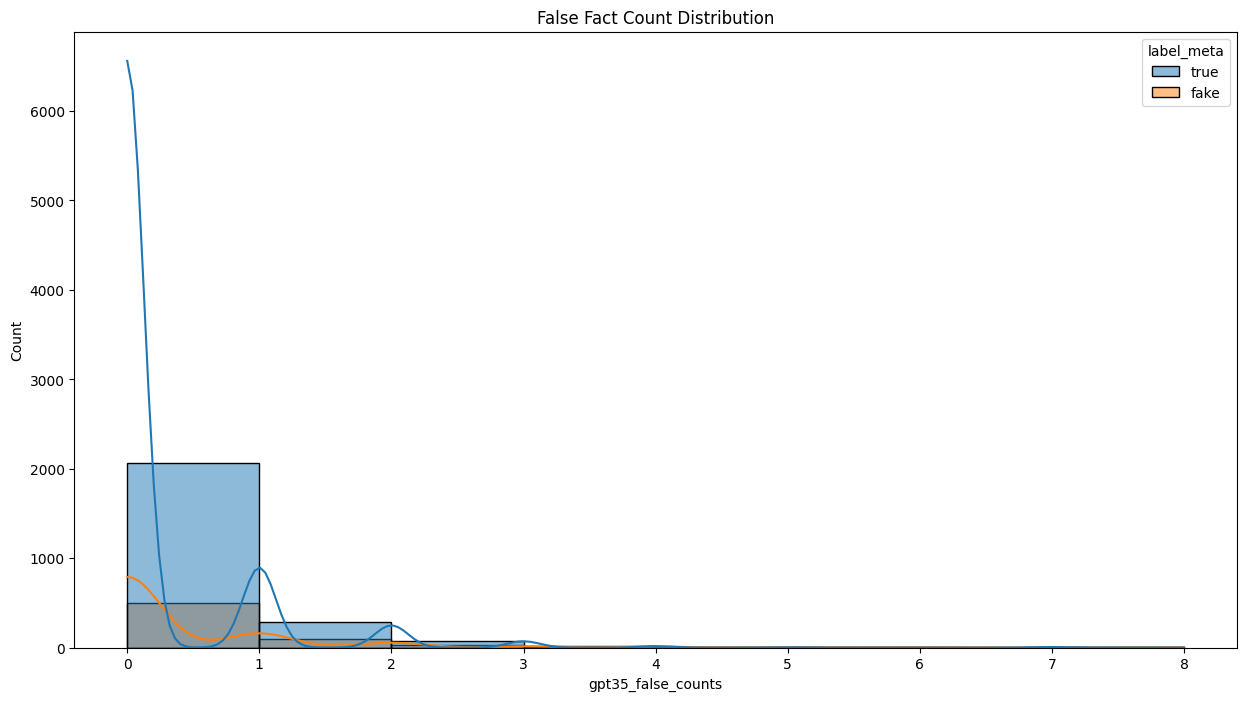

In [67]:
# Fact count
plt.figure(figsize=(15,8))

# Histogram
gft_false_count = sns.histplot(data=gpt_true_facts, x='gpt35_false_counts', binwidth=1, kde=True, hue='label_meta')
gft_false_count.set_title('False Fact Count Distribution')

# Show
plt.show()

In [68]:
# Grouping
gpt_true_facts.groupby(['label_meta'])['gpt35_false_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label_meta,,,,,,,,
fake,653.0,0.396631,0.917011,0.0,0.0,0.0,0.0,8.0
true,2451.0,0.221134,0.597322,0.0,0.0,0.0,0.0,7.0


In [69]:
# Perform Kolmogorov-Smirnov Test - Are they from the same distribution?
gft_false_ks = stats.ks_2samp(gpt_true_facts.gpt35_false_counts[gpt_true_facts.label_meta=='fake'], gpt_true_facts.gpt35_false_counts[gpt_true_facts.label_meta=='fake'])
p_value = gft_false_ks.pvalue

# Print out the results
if p_value < (0.05/2):
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


### Undetermined counts

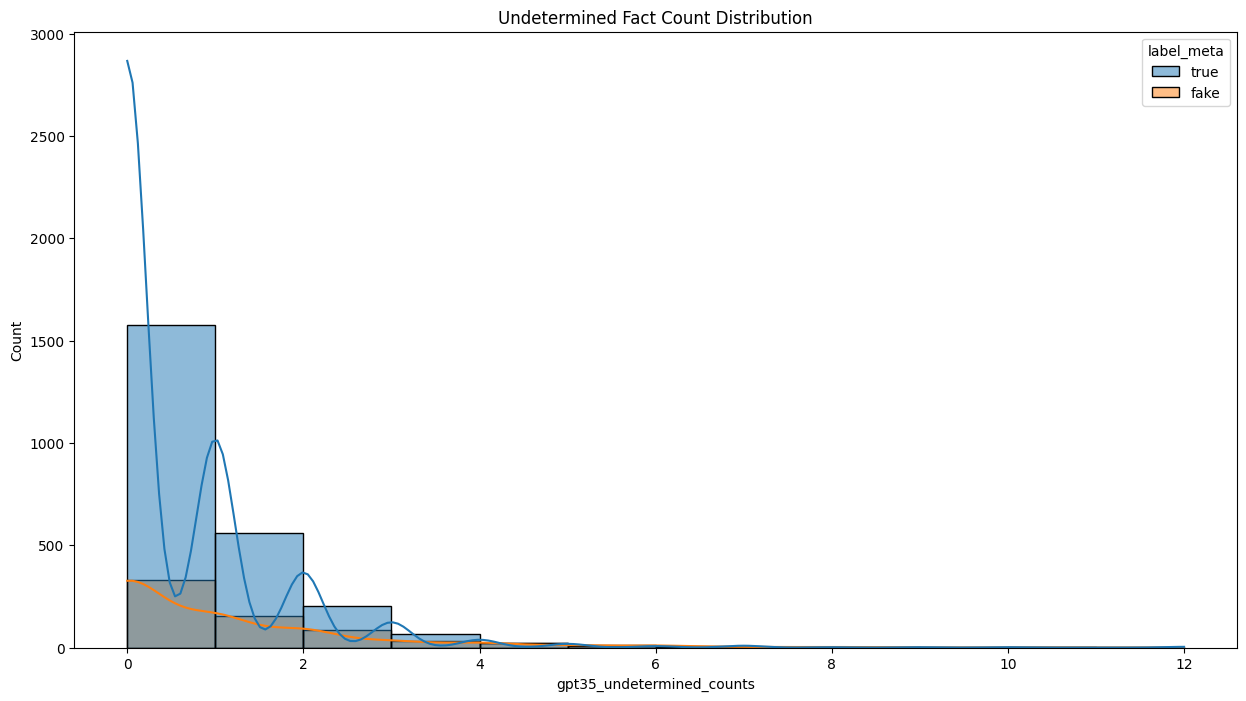

In [70]:
# Fact count
plt.figure(figsize=(15,8))

# Histogram
gft_undetermined_count = sns.histplot(data=gpt_true_facts, x='gpt35_undetermined_counts', binwidth=1, kde=True, hue='label_meta')
gft_undetermined_count.set_title('Undetermined Fact Count Distribution')

# Show
plt.show()

In [71]:
# Grouping
gpt_true_facts.groupby(['label_meta'])['gpt35_undetermined_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
label_meta,,,,,,,,
fake,653.0,1.041348,1.521766,0.0,0.0,0.0,2.0,10.0
true,2451.0,0.576091,1.044824,0.0,0.0,0.0,1.0,12.0


In [72]:
# Perform Kolmogorov-Smirnov Test - Are they from the same distribution?
gft_undetermined_ks = stats.ks_2samp(gpt_true_facts.gpt35_undetermined_counts[gpt_true_facts.label_meta=='fake'], gpt_true_facts.gpt35_undetermined_counts[gpt_true_facts.label_meta=='fake'])
p_value = gft_undetermined_ks.pvalue

# Print out the results
if p_value < (0.05/2):
    print("The two distributions have different shapes.")
else:
    print("The two distributions have similar shapes.")

The two distributions have similar shapes.


## GPT False Fact Classification

## Fact Counts: Actual vs. Classified

|actual fake| actual true|
|----|----
|ff_fact|tf_fact|
|ft_fact|tt_fact|

In [73]:
# Build data for comparison
# Actual true - gpt true
tt_fact = gpt_true_facts.fact_counts[(gpt_true_facts.label_meta == 'true') & (gpt_true_facts.gpt_classification == 'real')]
tt_fact_sum = sum([i for i in tt_fact])

# Actual fake - gpt true
ft_fact = gpt_true_facts.fact_counts[(gpt_true_facts.label_meta == 'fake') & (gpt_true_facts.gpt_classification == 'real')]
ft_fact_sum = sum([i for i in ft_fact])

# Actual fake - gpt fake
ff_fact = gpt_fake_facts.fact_counts[(gpt_fake_facts.label_meta == 'fake') & (gpt_fake_facts.gpt_classification == 'fake')]
ff_fact_sum = sum([i for i in ff_fact])

# Actual true - gpt fake
tf_fact = gpt_fake_facts.fact_counts[(gpt_fake_facts.label_meta == 'true') & (gpt_fake_facts.gpt_classification == 'fake')]
tf_fact_sum = sum([i for i in tf_fact])

In [74]:
# Fact count contingency analysis
fact_chi2, fact_p, fact_dof, fact_expected = stats.chi2_contingency(np.array([[ff_fact_sum, tf_fact_sum],[ft_fact_sum, tt_fact_sum]]), correction=True)

In [75]:
# output
print(f'Chi-Squared: {fact_chi2}\np-value: {fact_p}\nDegrees of Freedom: {fact_dof}')

Chi-Squared: 1213.4986451444836
p-value: 7.10690597953477e-266
Degrees of Freedom: 1


In [76]:
# Expected values
print(f'Expected values: {fact_expected}\n\nObserved values: {np.array([[ff_fact_sum, tf_fact_sum],[ft_fact_sum, tt_fact_sum]])}')

Expected values: [[   55.18979266   231.81020734]
 [ 5008.81020734 21038.18979266]]

Observed values: [[  287     0]
 [ 4777 21270]]


This shows that at least for fact counts, there is some sort of association between actual classification categories of articles and gpt classification categories of articles.

## True Counts: Actual vs. Classified


|(A/C)          | actual_fake   | actual_true             |
|---------------|---------------|-------------------------|
|classified_fake| apt_fake_data | apt_true_data           |
|classified_true| cpt_fake_data | cpt_true_data           |

In [77]:
# Actual true - gpt true
apt_true_data = gpt_true_facts.gpt35_true_counts[(gpt_true_facts.label_meta == 'true') & (gpt_true_facts.gpt_classification == 'real')]
apt_true_sum = sum([i for i in apt_true_data])

# Actual fake - gpt true
apt_fake_data = gpt_true_facts.gpt35_true_counts[(gpt_true_facts.label_meta == 'fake') & (gpt_true_facts.gpt_classification == 'real')]
apt_fake_sum = sum([i for i in apt_fake_data])

# Actual fake - gpt fake
cpt_fake_data = gpt_fake_facts.gpt35_true_counts[(gpt_fake_facts.label_meta == 'fake') & (gpt_fake_facts.gpt_classification == 'fake')]
cpt_fake_sum = sum([i for i in cpt_fake_data])

# Actual true - gpt fake
cpt_true_data = gpt_fake_facts.gpt35_true_counts[(gpt_fake_facts.label_meta == 'true') & (gpt_fake_facts.gpt_classification == 'fake')]
cpt_true_sum = sum([i for i in cpt_true_data])

In [78]:
# Fact count contingency analysis
true_chi2, true_p, true_dof, true_expected = stats.chi2_contingency(np.array([[cpt_fake_sum, cpt_true_sum],[apt_fake_sum, apt_fake_sum]]), correction=True)

In [79]:
# output
print(f'Chi-Squared: {true_chi2}\np-value: {true_p}\nDegrees of Freedom: {true_dof}')

Chi-Squared: 138.42971355689997
p-value: 5.869653732116453e-32
Degrees of Freedom: 1


In [80]:
# Expected values
print(f'Expected values: {true_expected}\n\nObserved values: {np.array([[cpt_fake_sum, cpt_true_sum],[apt_fake_sum, apt_fake_sum]])}')

Expected values: [[  72.81201078   70.18798922]
 [3895.18798922 3754.81201078]]

Observed values: [[ 143    0]
 [3825 3825]]


For true counts, there is some sort of association between actual classifications and gpt classifications of articles.

## False Counts: Actual vs. Classified

|(A/C)          | actual_fake     | actual_true             |
|---------------|-----------------|-------------------------|
|classified_fake| ff_false        | tf_false                |
|classified_true| ft_false        | tt_false                |

In [81]:
# Build data for comparison
# Actual true - gpt true
tt_false = gpt_true_facts.gpt35_false_counts[(gpt_true_facts.label_meta == 'true') & (gpt_true_facts.gpt_classification == 'real')]
tt_false_sum = sum([i for i in tt_false])

# Actual fake - gpt true
ft_false = gpt_true_facts.gpt35_false_counts[(gpt_true_facts.label_meta == 'fake') & (gpt_true_facts.gpt_classification == 'real')]
ft_false_sum = sum([i for i in ft_false])

# Actual fake - gpt fake
ff_false = gpt_fake_facts.gpt35_false_counts[(gpt_fake_facts.label_meta == 'fake') & (gpt_fake_facts.gpt_classification == 'fake')]
ff_false_sum = sum([i for i in ff_false])

# Actual true - gpt fake
tf_false = gpt_fake_facts.gpt35_false_counts[(gpt_fake_facts.label_meta == 'true') & (gpt_fake_facts.gpt_classification == 'fake')]
tf_false_sum = sum([i for i in tf_false])

In [82]:
# Count contingency analysis
false_chi2, false_p, false_dof, false_expected = stats.chi2_contingency(np.array([[ff_false_sum, tf_false_sum],[ft_false_sum, tt_false_sum]]), correction=True)

In [83]:
# output
print(f'Chi-Squared: {false_chi2}\np-value: {false_p}\nDegrees of Freedom: {false_dof}')

Chi-Squared: 98.56264130230743
p-value: 3.1490426124006777e-23
Degrees of Freedom: 1


In [84]:
# Expected values
print(f'Expected values: {false_expected}\n\nActual values: {np.array([[ff_false_sum, tf_false_sum],[ft_false_sum, tt_false_sum]])}')

Expected values: [[ 20.17523364  34.82476636]
 [293.82476636 507.17523364]]

Actual values: [[ 55   0]
 [259 542]]


## Undetermined Counts: Actual vs. Classified


|(A/C)          | actual_fake     | actual_true             |
|---------------|-----------------|-------------------------|
|classified_fake| ff_undetermined | tf_undetermined         |
|classified_true| ft_undetermined | tt_undetermined         |

In [85]:
# Build data for comparison
# Actual true - gpt true
tt_undetermined = gpt_true_facts.gpt35_undetermined_counts[(gpt_true_facts.label_meta == 'true') & (gpt_true_facts.gpt_classification == 'real')]
tt_undetermined_sum = sum([i for i in tt_undetermined])

# Actual fake - gpt true
ft_undetermined = gpt_true_facts.gpt35_undetermined_counts[(gpt_true_facts.label_meta == 'fake') & (gpt_true_facts.gpt_classification == 'real')]
ft_undetermined_sum = sum([i for i in ft_undetermined])

# Actual fake - gpt fake
ff_undetermined = gpt_fake_facts.gpt35_undetermined_counts[(gpt_fake_facts.label_meta == 'fake') & (gpt_fake_facts.gpt_classification == 'fake')]
ff_undetermined_sum = sum([i for i in ff_undetermined])

# Actual true - gpt fake
tf_undetermined = gpt_fake_facts.gpt35_undetermined_counts[(gpt_fake_facts.label_meta == 'true') & (gpt_fake_facts.gpt_classification == 'fake')]
tf_undetermined_sum = sum([i for i in tf_undetermined])

In [86]:
# Count contingency analysis
und_chi2, und_p, und_dof, und_expected = stats.chi2_contingency(np.array([[ff_undetermined_sum, tf_undetermined_sum],[ft_undetermined_sum, tt_undetermined_sum]]), correction=True)

In [87]:
# output
print(f'Chi-Squared: {und_chi2}\np-value: {und_p}\nDegrees of Freedom: {und_dof}')

Chi-Squared: 145.95531478297747
p-value: 1.3277306780055112e-33
Degrees of Freedom: 1


In [88]:
# Expected values
print(f'Expected values: {und_expected}\n\nObserved values: {np.array([[ff_undetermined_sum, tf_undetermined_sum],[ft_undetermined_sum, tt_undetermined_sum]])}')

Expected values: [[  26.8736745   50.1263255]
 [ 730.1263255 1361.8736745]]

Observed values: [[  77    0]
 [ 680 1412]]


For undetermined counts, there is an association between actual classifications and gpt classifications of articles.

Overall, this indicates that content, such as facts identified, and the amounts identified as true, false, or undetermined underlie the LLM's decision to classify something as a real news article. There appears to be a similarity in counts of each between actual real and actual fake articles that were classified by the LLM as real articles.